In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, Merge, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

Using TensorFlow backend.


In [24]:
dj = pd.read_csv("DJIA_table.csv")
news = pd.read_csv("RedditNews.csv")

In [25]:
dj.head()


,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [26]:
dj.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [27]:
news.head()


,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [28]:
print(dj.shape)
print(news.shape)

(1989, 7)
(73608, 2)


In [29]:
print(len(set(dj.Date)))
print(len(set(news.Date)))


1989
2943


In [30]:
#to ensure that we have the same dates in wach dataframe
news = news[news.Date.isin(dj.Date)]

In [31]:
print(len(set(dj.Date)))
print(len(set(news.Date)))


1989
1989


In [32]:
# Calculate the difference in opening prices between the following and current day.
# since model will try to predict how much the Open value will change beased on the news.
dj = dj.set_index('Date').diff(periods=1)
dj['Date'] = dj.index
dj = dj.reset_index(drop=True)
# Remove unneeded features
dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)

In [33]:
dj.head()

,Open,Date
0,NaN,2016-07-01
1,-211.480468,2016-06-30
2,-256.740235,2016-06-29
3,-265.509765,2016-06-28
4,164.701172,2016-06-27


In [34]:
dj = dj[dj.Open.notnull()]

In [35]:

# Check if there are any more null values.
dj.isnull().sum()

Open    0
Date    0
dtype: int64

In [36]:

# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
headlines = []

for row in dj.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Open'])
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])
    
    # Track progress
    headlines.append(daily_headlines)
    if len(price) % 500 == 0:
        print(len(price))

print ('[%s]' % ', '.join(map(str, price)))


500
1000
1500
[-211.48046800000157, -256.7402349999975, -265.5097650000025, 164.70117200000095, 591.4199210000006, -102.52148400000078, -11.439452999999048, -5.339844000001904, -90.46093699999983, -3.4296880000001693, -131.20898400000078, 101.41992200000095, 7.119140000002517, 119.73046899999827, 108.32031199999983, 31.160156999998435, -38.07031299999653, 4.310546999997314, -110.53125, -25.888671999997314, -10.75, -34.5, 136.94921899999827, -64.65039099999922, 32.66992200000095, -124.42968700000347, -209.90039099999922, -18.150390999999217, -69.71875, 76.8398440000019, -12.880859000000783, 200.18164099999922, -169.70117200000095, 179.359375, 0.0, 207.91015600000173, -192.36914099999922, 17.189452999999048, -93.54882799999905, 14.179687999996531, 70.53906200000347, 135.73046899999827, -86.97070299999905, 29.310546999997314, 210.79101500000252, -27.740234000000783, -8.759765999999217, 3.5585939999982656, -5.888671999997314, 107.78906299999653, -33.34960999999748, -47.390625, -121.9003900

In [37]:
# Compare lengths to ensure they are the same
print(len(price))
print(len(headlines))

1988
1988


In [38]:
# Compare no. of headlines for each day

print(max(len(i) for i in headlines))
print(max(len(i) for i in headlines))
print(max(len(i) for i in headlines))

25
25
25


In [39]:
#Boilerplate most common english contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [40]:
def clean_text(text, remove_stopwords=True):
    
    #Convert all to lower case
    text=text.lower()
    
    #Expand Contractions
    if True:
        text=text.split()
        new_text=[]
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text=" ".join(new_text)
        
        
    #Format words and remove unwanted charecters(Noise)
    #Boilerplate
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    
    return  text
                
                

In [41]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [42]:
clean_headlines[0]

['jamaica proposes marijuana dispensers tourists airports following legalisation kiosks desks would give people license purchase 2 ounces drug use stay',
 'stephen hawking says pollution stupidity still biggest threats mankind certainly become less greedy less stupid treatment environment past decade',
 'boris johnson says run tory party leadership',
 'six gay men ivory coast abused forced flee homes pictured signing condolence book victims recent attack gay nightclub florida',
 'switzerland denies citizenship muslim immigrant girls refused swim boys report',
 'palestinian terrorist stabs israeli teen girl death bedroom',
 'puerto rico default $ 1 billion debt friday',
 'republic ireland fans awarded medal sportsmanship paris mayor',
 'afghan suicide bomber kills 40 bbc news',
 'us airstrikes kill least 250 isis fighters convoy outside fallujah official says',
 'turkish cop took istanbul gunman hailed hero',
 'cannabis compounds could treat alzheimer removing plaque forming proteins br

In [43]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

for key,val in word_counts.items():
    print (key, "=>", val)

Size of Vocabulary: 35190
jamaica => 23
proposes => 65
marijuana => 220
dispensers => 1
tourists => 97
airports => 33
following => 219
legalisation => 4
kiosks => 2
desks => 1
would => 878
give => 289
people => 1887
license => 21
purchase => 26
2 => 733
ounces => 2
drug => 656
use => 605
stay => 109
stephen => 64
hawking => 23
says => 2563
pollution => 135
stupidity => 8
still => 327
biggest => 331
threats => 119
mankind => 13
certainly => 12
become => 314
less => 204
greedy => 6
stupid => 30
treatment => 134
environment => 96
past => 242
decade => 109
boris => 23
johnson => 24
run => 291
tory => 24
party => 512
leadership => 54
six => 303
gay => 444
men => 524
ivory => 106
coast => 209
abused => 54
forced => 334
flee => 91
homes => 199
pictured => 4
signing => 23
condolence => 2
book => 90
victims => 240
recent => 178
attack => 951
nightclub => 11
florida => 11
switzerland => 117
denies => 113
citizenship => 77
muslim => 516
immigrant => 28
girls => 230
refused => 97
swim => 18
boys =

petition => 59
popular => 87
crashing => 7
north => 1271
korea => 1214
printing => 16
massive => 251
amounts => 37
fake => 134
currency => 121
defectors => 28
sinn => 6
fein => 6
irish => 192
reunification => 16
70 => 133
sharemarket => 1
disowns => 2
350m => 1
nhs => 41
hours => 266
soon => 138
possible => 184
350 => 21
fund => 135
big => 269
mistake => 50
captions => 1
takes => 178
every => 299
send => 155
stamped => 2
material => 64
london => 425
banking => 95
job => 134
start => 161
large => 186
spike => 13
searches => 22
passport => 43
applications => 12
broke => 74
backs => 67
remain => 85
94 => 17
night => 149
residents => 142
guilty => 193
insulting => 81
recep => 24
tayyip => 28
depicting => 14
gollum => 2
character => 15
lord => 57
rings => 12
antalya => 1
province => 77
rifat => 1
cetin => 1
jail => 322
sentence => 122
stripped => 43
parental => 7
custody => 54
today => 374
decides => 31
whether => 128
e => 109
cigarettes => 32
public => 567
warn => 93
ban => 637
using => 34

dam => 46
projects => 40
logging => 27
ontario => 44
funeral => 33
dissolves => 11
pours => 3
sewers => 3
declassified => 22
reveal => 184
tortured => 103
tens => 106
gathered => 45
sweltering => 3
heat => 54
okinawa => 25
demonstrations => 65
decades => 163
bases => 62
arrest => 266
suspected => 228
murdering => 30
local => 214
woman => 589
dementia => 7
crisis => 516
hits => 204
levels => 126
go => 379
missing => 245
national => 419
reports => 292
12 => 271
patients => 99
hundreds => 342
later => 116
icelands => 8
hekla => 1
volcano => 76
tourist => 74
destination => 16
ready => 197
blow => 81
pledges => 45
ttip => 51
elected => 69
ransack => 3
stores => 29
hunger => 78
grips => 6
nation => 249
street => 170
gangs => 59
fought => 46
rome => 48
elects => 18
female => 260
kuwait => 44
angry => 98
hillary => 39
clintons => 2
claims => 435
embassies => 21
canberra => 5
denounced => 14
candidate => 55
remarks => 28
also => 304
suffer => 37
professor => 58
dismissed => 37
soldier => 162
di

festival => 33
bollywood => 8
celebrating => 11
overrule => 3
chief => 412
censor => 36
sought => 36
controversial => 163
punjab => 11
militants => 218
massacres => 12
civilians => 249
ghandoura => 1
aleppo => 34
villagers => 51
donate => 23
build => 201
community => 112
reviews => 4
scholar => 18
mongolia => 22
changing => 40
addresses => 24
word => 52
phrases => 3
developed => 67
startup => 6
identifies => 16
9 => 215
square => 163
meter => 11
spaces => 12
anywhere => 26
words => 73
praying => 15
academic => 28
laser => 15
technology => 99
medieval => 28
hidden => 74
cambodian => 17
jungle => 29
hostage => 71
robert => 62
hall => 15
beheaded => 53
abu => 42
sayyaf => 2
imam => 28
quran => 10
punishment => 58
homosexuals => 38
dutch => 249
drugged => 6
upscale => 2
doha => 6
convicted => 169
wedlock => 4
qatari => 14
orlando => 2
denmark => 112
school => 343
website => 118
perverts => 3
bar => 39
democrat => 7
introducing => 6
liberal => 52
decriminalize => 17
simple => 27
possession 

god => 96
ganesh => 1
servants => 19
fasting => 7
male => 76
transgenders => 2
earliest => 15
controlled => 31
charred => 4
bone => 13
rippled => 1
cave => 33
date => 37
800000 => 11
heated => 8
bones => 29
fossils => 13
tools => 20
argue => 15
600000 => 14
creates => 36
agencies => 84
centralise => 1
rocks => 54
district => 32
bus => 125
kids => 87
diagnosed => 11
thyroid => 8
check => 43
upping => 5
131 => 5
radiation => 124
unlikely => 34
cause => 128
priest => 80
decriminalizing => 15
alarming => 26
ransomware => 3
tracked => 20
doctor => 94
dying => 68
recall => 19
monsanto => 63
roundup => 9
limited => 22
glyphosate => 3
hawkings => 3
finally => 114
solution => 78
hole => 38
paradox => 5
allies => 83
exercise => 38
cold => 87
clear => 102
message => 100
hagia => 1
sophia => 1
prayers => 16
historic => 85
fundamentalist => 11
obey => 10
unnatural => 4
favouring => 3
creationism => 7
evolution => 24
belfasttelegraph => 3
norwegian => 121
diplomatic => 100
open => 253
toilet => 26
s

intercepting => 6
patrolling => 8
americas => 37
prompting => 26
combat => 90
provocations => 6
worries => 19
dawn => 43
informal => 5
idomeni => 1
macedonian => 3
blocking => 62
sending => 118
keeps => 29
happening => 53
survivor => 31
presence => 54
continued => 33
saturday => 54
formal => 21
complaint => 27
apologize => 24
austria => 42
denial => 40
arguments => 8
test => 182
pepsi => 8
economist => 54
statisticians => 1
mainstream => 23
accurate => 7
contrarian => 3
misleading => 18
retake => 20
begun => 59
shuttle => 5
harmony => 2
hindus => 17
territories => 37
160 => 17
handful => 7
joined => 33
formally => 37
submitted => 12
resignation => 46
samoa => 13
amending => 2
constitution => 62
churches => 42
chemicals => 33
pounced => 1
unsolicited => 1
40bn => 3
27bn => 1
reuters => 131
lethal => 19
embargo => 28
olympians => 5
rival => 49
shifts => 22
constitutional => 57
criminals => 53
survey => 89
64 => 22
europeans => 51
dormitory => 4
hopes => 58
voice => 47
contested => 10
isl

euthanised => 1
irreparable => 4
ptsd => 2
owned => 71
bee => 16
harming => 13
pesticides => 35
farming => 35
application => 9
pesticide => 14
rules => 296
neonicotinoids => 9
shells => 43
bullets => 40
heavy => 94
shelling => 30
slashed => 14
54 => 20
essential => 22
commonly => 5
hypertension => 1
spark => 18
blown => 34
harvard => 10
dilma => 18
trial => 272
senate => 71
senators => 12
participating => 11
todays => 11
impeachment => 15
pending => 10
yes => 53
bitter => 15
debate => 150
pitted => 1
renzi => 2
couples => 54
recites => 1
explicit => 13
bestiality => 3
unleashes => 8
tanks => 98
listed => 15
stock => 66
collective => 15
capitalisation => 2
225bn => 1
havens => 27
389 => 1
overseas => 56
protectorates => 2
rebuked => 6
personnel => 34
suggesting => 38
imagery => 10
diocese => 6
reinstates => 6
goes => 164
bolsters => 2
defenses => 3
mh370 => 43
active => 32
3m => 9
payment => 33
questions => 85
yearly => 6
revenue => 14
halved => 11
activates => 5
prepares => 56
roll => 

binladin => 1
lays => 12
uae => 38
mountain => 42
improve => 42
rainfall => 5
pirates => 131
costs => 83
roof => 19
knocking => 5
tactic => 10
tips => 10
gratuities => 1
restaurants => 24
scrapped => 19
review => 58
tipping => 9
maybe => 22
feared => 52
captured => 128
soldiers => 437
somalia => 125
apologises => 15
oxy => 1
ssak => 2
liquid => 14
humidifier => 1
disinfectant => 1
reckitt => 2
benckiser => 2
103 => 10
ttipleaks => 1
training => 67
maritime => 23
militia => 34
disputed => 62
artillery => 43
vw => 15
teens => 42
sympathisers => 1
helicopter => 57
carrying => 131
unauthorised => 9
sightseeing => 2
flights => 72
everest => 27
nepalese => 10
sherpas => 3
vibrations => 2
helicopters => 37
avalanches => 3
beret => 3
tonne => 8
unearthed => 46
preachers => 8
boeing => 22
lockheed => 12
monopoly => 21
woolly => 6
wolf => 14
nepal => 54
poop => 3
subspecies => 3
gray => 8
disciplined => 5
legalises => 7
empathy => 2
feel => 76
desperate => 45
circumstances => 19
cloud => 35
judg

investigations => 28
uncovered => 45
lapses => 2
diligence => 1
failures => 10
interaction => 4
involving => 39
reddit => 82
deletes => 7
canary => 4
monaco => 3
unaoil => 1
corrupted => 3
nk => 16
enemy => 46
shitty => 4
officially => 89
youtube => 86
underscores => 6
concern => 45
available => 50
deport => 17
dicaprio => 5
immigration => 76
ronny => 1
sompie => 1
revoked => 15
rewrite => 14
vikings => 6
archaeologists => 57
hearth => 1
viking => 14
norse => 2
undertaking => 4
erupt => 26
discuss => 46
installed => 24
malware => 21
monitor => 50
columbias => 1
successful => 41
usage => 15
capita => 19
molenbeek => 2
megafund => 1
norways => 11
whale => 43
hunts => 15
fur => 5
driver => 55
junead => 1
scout => 2
usaf => 6
anglia => 1
develop => 36
graphite => 2
filaments => 1
float => 6
electrical => 12
grids => 6
obese => 13
640 => 3
rang => 5
slept => 3
hijack => 21
jamming => 7
gps => 17
signals => 27
planes => 58
cellphones => 9
operate => 15
afghans => 47
int => 12
stadium => 21
s

blows => 27
tasman => 1
tortilla => 2
arriving => 17
milk => 54
laced => 5
urea => 1
paint => 9
polio => 60
delays => 11
licensing => 3
acres => 21
panels => 28
kilowatt => 1
sinks => 21
cites => 18
puppy => 2
thawed => 1
remarkable => 21
happiest => 10
234 => 3
hectares => 19
seam => 1
pulls => 30
xis => 1
rescuers => 12
shahid => 1
afridi => 4
documentary => 63
exposes => 39
canned => 3
hunting => 74
bred => 3
reared => 1
enclosed => 2
guaranteeing => 4
trophy => 9
hunter => 9
applied => 11
intentionally => 13
neandertals => 1
novembers => 1
wrongful => 4
luiz => 1
inacio => 1
silva => 5
successor => 10
prosecution => 50
petrobras => 4
supermarkets => 23
alphago => 2
ai => 26
dol => 4
hiker => 5
coin => 9
kind => 75
augustus => 1
emperor => 11
empire => 33
minted => 1
honoring => 2
rulers => 29
teresa => 6
saint => 8
stabbed => 44
southwestern => 8
yunnan => 1
alleviate => 3
broaden => 2
karun => 1
misra => 1
weaker => 2
vetting => 2
accidents => 14
belfast => 14
invisibility => 4
cl

pretty => 30
scary => 11
suddenly => 31
pendant => 1
piece => 42
mesolithic => 2
shaman => 2
sheet => 5
round => 45
coptic => 22
ubs => 16
discriminates => 4
wto => 11
gear => 29
drills => 18
odins => 1
allah => 20
flow => 23
boasts => 7
brilliant => 5
dressed => 19
womble => 1
shiite => 21
muqtada => 2
sadr => 6
haider => 3
abadi => 2
craze => 5
thumb => 3
monkeys => 14
trend => 15
pygmy => 3
marmosets => 1
pets => 9
survive => 35
shallow => 4
fatality => 9
fisherman => 15
drowned => 15
hitlers => 5
seller => 6
lille => 2
deepcut => 1
organized => 46
skip => 3
billionaires => 28
250m => 2
undersea => 15
cable => 52
espionage => 44
tech => 56
giants => 33
psa => 2
peugeot => 1
citroen => 2
ninth => 6
manufacturer => 27
net => 97
989 => 1
00 => 15
bonus => 28
dividends => 3
premises => 8
47 => 39
log => 9
motives => 6
felling => 2
pest => 4
leveling => 1
explain => 42
hungarys => 2
orban => 6
tone => 9
quotas => 11
uncontrolled => 2
criminality => 3
semitism => 24
survivors => 46
dragge

worrying => 13
valuables => 2
jewelry => 5
lodging => 1
canceled => 12
550 => 9
journey => 13
attracted => 8
stunning => 26
riposte => 1
michael => 42
liebreich => 1
arm => 47
lp => 1
francois => 13
idea => 79
marseille => 6
misspent => 1
quick => 16
aus => 4
opera => 7
ferries => 2
welcomes => 12
cecil => 12
dentist => 9
declined => 10
kippot => 1
ractopamine => 1
weight => 21
vladimimr => 1
pribylovsky => 1
author => 32
alan => 20
kurdi => 1
30/barrel => 1
december => 37
coach => 7
samar => 2
guardian => 132
marrying => 12
costly => 10
meaningless => 5
letting => 19
pompeii => 6
dwellings => 1
fm => 25
randomly => 6
fallen => 30
insiders => 6
promptly => 5
kippa => 2
garda => 3
upwards => 4
learned => 23
core => 28
arak => 1
fills => 6
concrete => 27
fulfilling => 5
olds => 10
sultanahmet => 1
nestle => 8
harvest => 28
cocoa => 3
gravity => 5
choir => 3
benedicts => 2
transgendered => 3
artist => 45
depravity => 3
mall => 20
advised => 16
brace => 12
cataclysmic => 1
16/brl => 1
coll

cern => 7
commandeer => 2
snapchat => 3
shrimp => 9
peeled => 3
seafood => 7
ramming => 4
sanction => 10
kimberly => 1
competitor => 5
granting => 14
alternatives => 8
incarceration => 2
abolish => 18
lexmark => 1
pesos => 2
rulings => 6
3/4 => 2
butterfly => 5
chris => 20
packham => 1
kosovo => 30
shorter => 5
cheapest => 6
maryland => 3
received => 92
mohamed => 36
elshinawy => 1
diagnosis => 2
labourers => 4
fern => 2
unpublished => 3
consistently => 5
overlooked => 2
militias => 23
forms => 21
nanotechnology => 5
biomedicine => 1
smart => 26
iss => 15
adequately => 3
directive => 10
amateur => 17
treasure => 24
embankment => 1
acquitted => 14
maternal => 3
exposure => 13
ssris => 1
painkillers => 4
types => 6
identical => 5
painkiller => 1
viable => 10
expenses => 19
drastically => 5
nationale => 1
routed => 3
stampede => 17
411 => 2
pilgrims => 10
acknowledged => 18
725 => 3
typhoon => 37
squad => 34
operators => 14
yahya => 3
jammeh => 2
gambia => 10
patience => 15
520 => 2
stirr

dissolution => 4
g20 => 96
wrongly => 15
depicted => 6
corralled => 1
wheelchair => 12
spectators => 4
balcony => 6
individually => 3
liberate => 10
pyramids => 17
illuminated => 1
colors => 3
78 => 24
copy => 28
homeopathy => 8
blacklisted => 5
treatments => 11
prescribing => 6
firefighters => 10
jetpacks => 1
aegean => 3
kane => 1
located => 18
geo => 3
zmirs => 1
dikili => 1
mentioned => 5
protections => 11
banknote => 1
commemorating => 6
defiance => 16
sleep => 28
mcdonalds => 14
theory => 28
wrest => 3
coffin => 9
hazara => 1
burst => 23
bhp => 7
300k => 2
452 => 1
propping => 4
smaller => 16
eus => 4
shenzhen => 4
narcotics => 13
crocodiles => 10
piranhas => 2
meth => 23
soaking => 2
floodgate => 2
handouts => 8
cutting => 47
interesting => 31
iraqs => 8
ensnaring => 1
traps => 12
blackmailing => 1
tricking => 3
duplicitous => 1
gifts => 9
really => 116
progress => 31
concedes => 10
malfunction => 4
suffocates => 1
probed => 3
olive => 24
scam => 25
bertolli => 1
sasso => 1
cara

fixing => 19
metals => 20
27th => 1
skywatching => 1
1982 => 11
supermoon => 2
diameter => 1
proximity => 3
reddish => 1
hue => 1
lunar => 11
eclipse => 6
canceling => 3
mayo => 1
evaluation => 4
700k => 2
bribe => 18
nike => 10
717 => 1
863 => 1
raving => 1
nonsense => 8
visited => 20
apart => 30
outstrips => 3
mix => 11
bioenergy => 1
favored => 3
rigged => 11
transponders => 2
pile => 17
eakin => 1
coordinator => 2
noaa => 1
sulfuric => 1
en => 20
praised => 13
stressing => 2
polluter => 4
barrick => 1
241 => 2
390 => 3
irbil => 1
lobbied => 6
privately => 12
flaws => 5
generic => 12
kit => 8
booklet => 1
activism => 11
juvenile => 5
offender => 9
automakers => 3
x3 => 1
strongholds => 3
butchered => 2
brown => 56
vault => 13
svalbard => 5
hiked => 2
incurable => 3
kidney => 15
rewards => 2
hires => 18
winterkorn => 1
easy => 18
superiors => 5
ashraf => 4
ghani => 2
assured => 3
zimbabwes => 5
sable => 1
antelope => 5
freeway => 2
internships => 2
seabirds => 4
seabird => 1
masters 

vanished => 13
hibernate => 2
degraded => 4
saves => 23
nautilus => 2
brutalizes => 1
reappeared => 2
slips => 6
tombstones => 1
prolonged => 9
lows => 4
remnants => 3
lagoon => 2
5mln => 2
ceta => 3
depend => 9
crayfish => 1
leaker => 18
engineered => 11
signal => 22
booed => 4
heidenau => 1
womb => 2
nurtured => 2
uterus => 1
unimaginable => 9
variety => 5
annihilated => 1
ultimate => 15
slogan => 3
duty => 31
umbrellas => 6
sunrise => 2
censoring => 17
baidu => 2
landmines => 15
sk => 5
oleg => 3
sentsov => 1
defusing => 2
tall => 8
humanities => 1
isils => 1
supersize => 1
urals => 3
pierced => 2
spear => 4
disbelieve => 2
lesson => 14
heavyweights => 2
dhabi => 9
riled => 1
democrats => 11
nationalists => 9
archive => 13
surfers => 3
paradise => 15
brutality => 47
publics => 3
bashing => 2
ripple => 4
ashley => 3
madison => 4
snubbing => 1
anthem => 7
hockey => 12
envoys => 8
politwoops => 1
monitored => 20
kalashnikov => 11
stumbles => 3
painting => 18
pokemon => 2
firearms => 8


bass => 2
rifle => 16
expropriates => 1
fiscal => 11
humiliating => 5
thisisacoup => 1
mixing => 9
asphalt => 1
nanoparticles => 3
mechanism => 5
twist => 11
overcome => 7
cyclones => 2
leverage => 3
enclosures => 1
founders => 9
wheeler => 1
excludes => 2
begs => 6
sins => 4
cowardice => 3
generates => 5
drastic => 10
translates => 2
landmarks => 3
aksum => 1
fasil => 1
ghebbi => 1
16th => 3
obfuscate => 1
mislead => 3
quds => 4
radically => 4
reshaping => 2
sighting => 2
drachma => 3
repressive => 12
avatar => 3
networked => 4
blower => 7
chuck => 9
blazer => 3
ratings => 23
mocks => 7
1981 => 5
seawater => 9
standstill => 19
flagship => 7
hangs => 17
nokia => 8
50000km2 => 1
seafloor => 6
searched => 16
120000km2 => 1
persecution => 30
silvio => 44
senator => 24
battalion => 9
perpetrated => 4
practical => 4
kerch => 2
crimean => 18
1983 => 6
geoffrey => 1
howe => 3
instruct => 1
recognizing => 13
samsung => 20
unsuspecting => 2
floorboards => 1
playstation => 4
xbox => 5
decriminal

happens => 31
abstraction => 1
moons => 4
girlfriend => 16
joy => 7
diphtheria => 2
girona => 1
contacted => 4
1987 => 4
cavendish => 1
succumbing => 1
predecessor => 4
taiji => 7
technique => 10
foreigner => 6
deputies => 1
alerted => 5
orcas => 1
vicinity => 3
responsive => 2
propelled => 5
swing => 5
looted => 16
sideline => 1
ts => 5
negotiating => 8
surrendering => 5
exacerbating => 3
227 => 2
shifted => 11
defy => 30
malala => 28
yousafzai => 17
ball => 20
fernandez => 4
slowed => 3
rebuts => 1
heating => 5
paused => 2
mammals => 11
reintroduced => 1
fenced => 1
exterminated => 3
bilbys => 1
numbats => 1
bandicoots => 1
flourish => 2
furniture => 11
retailer => 7
upstaging => 1
trades => 6
cups => 2
neonatal => 2
pulp => 2
booming => 17
plutos => 1
unpredictably => 1
fixed => 16
binary => 1
colleges => 6
respiratory => 5
syndrome => 15
optimistic => 3
lithuanians => 3
drafted => 8
crying => 14
selfie => 5
swamped => 9
lowers => 7
buk => 4
saputo => 1
mistreat => 1
dairies => 1
no

olmert => 14
retrial => 5
methuselah => 1
courses => 9
lech => 6
awaits => 5
braving => 1
illness => 27
transat => 1
routine => 15
spookception => 1
incredulity => 1
appoint => 4
clue => 3
slowest => 3
options => 19
cane => 8
toads => 3
lined => 8
remedy => 2
premium => 3
venom => 1
anthony => 4
mcsweeney => 1
infidelity => 1
cappadocia => 1
biomed => 1
retracted => 6
broader => 8
publications => 6
welcoming => 6
chapel => 6
gym => 1
translators => 3
ripped => 10
reanalysis => 1
conclusive => 2
secondhand => 1
houthi => 2
humvees => 2
genocides => 2
resolved => 4
antidepressants => 2
studied => 5
essentially => 9
tauhid => 1
landmine => 4
draped => 1
219 => 2
clarkson => 4
kraft => 4
merge => 1
heinz => 1
bi => 2
partisan => 2
guilt => 9
harakiri => 1
colluded => 7
loyalist => 4
cartoonists => 1
implying => 2
gears => 2
skim => 5
occurrence => 2
activated => 3
prone => 6
izumo => 1
battled => 4
scrawled => 4
mcdonough => 1
j => 13
cyberwarfare => 4
ludlam => 2
dnepropetrovsk => 1
kolom

meteor => 8
reinforced => 3
sharia4belgium => 2
fouad => 2
belkacem => 1
minecraft => 1
defendant => 3
cementing => 2
cartoons => 28
gourma => 1
ump => 2
expired => 5
10s => 3
hoped => 10
bargaining => 3
spymaster => 1
vaccinewhich => 1
warts => 1
diseasesdo => 1
kayla => 2
mueller => 3
cpl => 2
franklin => 3
routs => 2
bjp => 2
gitmo => 16
magna => 3
carta => 3
scrapbook => 1
nocturnal => 1
adoptions => 6
1960s => 15
dredge => 8
mycoin => 1
hkd => 1
386 => 3
hooded => 5
couchsurfing => 3
drugging => 2
tyrant => 3
directors => 9
impasse => 2
deadlock => 3
offending => 15
lithuanian => 12
betray => 2
gallon => 3
declassifying => 1
curfew => 16
partying => 2
85kg => 1
nugget => 3
stakeout => 2
relies => 5
ante => 2
nasser => 2
judeh => 1
089 => 1
hurun => 1
fortunes => 3
unmarked => 4
inhuman => 9
tanning => 2
workshops => 4
deplorable => 2
surroundings => 1
knighthood => 4
disconnection => 6
unabashed => 1
unload => 3
advertisement => 9
indonesians => 8
demeaning => 2
insensitive => 1
c

swedes => 16
contiguous => 2
array => 6
irrawaddy => 1
gangetic => 1
theater => 9
khasan => 1
zakayev => 2
courageous => 6
minus => 3
slides => 4
rabbis => 15
rabbinate => 1
freely => 12
rubles => 5
smokes => 2
airplane => 8
hurried => 2
stocking => 1
accelerated => 11
cronies => 4
nazca => 5
grapples => 3
capitalization => 1
hafiz => 2
saeed => 4
adjust => 3
clergy => 16
moviegoers => 1
physicians => 6
rectal => 1
scaremongers => 1
spiteful => 1
tori => 1
psychologist => 3
waterboarded => 3
taker => 1
200k => 4
lindt => 1
chocolat => 1
commuters => 3
illridewithyou => 1
jacuzzis => 1
ps4 => 1
conditioning => 1
doll => 3
attendant => 3
arrangements => 3
interrogators => 4
heroes => 12
equating => 4
fundamentalists => 16
edible => 2
uneaten => 1
simultaneously => 10
novelty => 2
unsurprising => 1
downhill => 1
undo => 4
arrogance => 6
roared => 2
accomplished => 6
dilemma => 9
virtual => 11
severs => 6
asbestos => 10
elude => 2
untrained => 1
horrifying => 14
pamphlet => 2
justifies => 

avenues => 1
chilpancingo => 1
zindler => 1
tasmanias => 2
forestry => 6
develops => 8
jeffrey => 2
goldberg => 2
wetlands => 4
paperwork => 3
caley => 1
antares => 1
immense => 5
modernism => 1
mediaeval => 2
seljuk => 1
syringes => 2
appallingly => 1
needles => 5
coveted => 7
dispense => 1
pontifical => 1
wizard => 1
purges => 2
operas => 4
yonhap => 9
jacqui => 4
lambie => 1
financiers => 3
cans => 1
republics => 3
hinge => 2
ruthlessly => 3
oromo => 2
judiciary => 12
squadron => 4
shamelessly => 4
glenn => 36
greenwald => 46
villain => 2
embedding => 2
digitizing => 1
summoning => 2
demon => 1
blotter => 1
perpetrators => 11
kid => 19
1956 => 4
birth1st => 1
guess => 25
stranger => 6
fattoush => 1
escalated => 6
sixty => 5
toughen => 2
sequence => 1
spanned => 2
unilateral => 16
diktat => 1
raging => 7
mule => 1
stonewalled => 2
47s => 5
remake => 3
sydneys => 1
vincents => 1
vitaly => 1
churkin => 1
paramedics => 3
intimidated => 9
addressed => 4
christ => 12
mastered => 1
astrono

dino => 1
indicating => 3
foundboat => 1
repairs => 2
sealing => 3
achieves => 2
nebraska => 3
mushroom => 3
beekeepers => 4
syngenta => 1
reassures => 3
770 => 1
gaping => 3
calendar => 4
rightful => 2
preemptive => 5
910 => 1
degrade => 2
mohammeds => 1
apparel => 3
adverts => 8
sexualising => 1
fray => 2
turnaround => 2
15bn => 2
symbolically => 1
coahuila => 1
conversation => 11
rot => 6
martyrdom => 6
geckos => 1
dredged => 2
joachim => 1
misleads => 1
depts => 1
aksenov => 1
needing => 1
surgeries => 5
chasing => 4
restrict => 19
funders => 1
lawsons => 1
argues => 14
mitigation => 1
deradicalisation => 1
spearhead => 1
asserts => 4
reinstitutes => 1
wildleaks => 3
whistlebower => 1
eruption => 14
brarbunga => 3
perpetually => 1
dell => 2
bubonic => 6
anxiously => 2
needlessly => 3
state/military => 1
pablo => 3
escobar => 2
hitman => 11
3k => 2
assasinations => 2
superstitious => 2
dismembering => 3
thereby => 3
insurance => 16
proclaim => 2
rotations => 1
exiting => 1
244 => 3


decarbonising => 1
vincent => 3
gogh => 3
guardsmen => 2
nereus => 1
implodes => 2
defecate => 2
adreyevka => 1
correction => 5
1974 => 2
subsequent => 7
judgments => 1
lists => 9
transnistria => 1
moldavian => 1
blight => 1
redistribution => 2
soviets => 6
newsweek => 8
intricate => 1
afterlife => 3
amanpour => 5
juice => 8
selectively => 4
nw => 2
lankan => 44
portuguese => 10
motherland => 2
rebuff => 1
yatseniuk => 2
walkouts => 2
surrenders => 8
colonize => 2
ranged => 1
preferences => 1
336 => 1
qazvin => 1
dismayed => 6
terminations => 1
susilo => 1
bambang => 1
yudhoyono => 1
fomenting => 1
fomented => 1
mastercard => 16
parish => 2
falsify => 1
yingluck => 4
shinawatra => 5
yak => 1
spratly => 1
prosecutions => 11
distortion => 2
offence => 11
hydrocarbon => 1
/r/worldnews => 10
downvote => 1
swearbot => 1
obscenities => 2
autumn => 2
elshamy => 1
tora => 1
slovyansk => 2
ebbs => 1
taxs => 1
antarctica~ => 1
ingredient => 6
rodman => 6
rejuvenates => 1
muscles => 5
applicable 

wildly => 5
legitimise => 2
disquieting => 1
jpost => 4
truxtun => 1
bastion => 6
825 => 1
verdicts => 2
237 => 2
antiwar => 4
capsized => 3
binge => 5
bis => 1
307 => 2
clarifies => 2
mario => 5
balotelli => 2
globes => 2
/r/legalnews => 5
unforgivable => 1
criminalizing => 9
outlawing => 6
commision => 2
erotica => 1
whitewashes => 2
consideration => 1
wanders => 1
wahl => 1
implicates => 7
flannery => 1
261 => 1
1044 => 1
coolly => 2
ram => 2
heartless => 1
psychotherapy => 1
gasser => 1
statuses => 1
depart => 3
lend => 8
dreams => 6
bloodless => 1
stupor => 1
evangelist => 5
consultations => 1
382 => 2
3/3/14 => 1
georgias => 2
infographic => 11
204th => 1
entombed => 1
roused => 1
yulia => 3
superpowers => 1
opressed => 1
appeasement => 1
appease => 6
3500 => 4
batlic => 1
oblat => 1
3am => 1
paralympics => 4
swears => 2
8kg => 1
tackles => 3
himalayas => 4
repelled => 2
retaken => 2
heretofore => 1
inexplicable => 1
biochemical => 1
094 => 1
yelling => 1
gems => 5
separates => 2

farrar => 1
wellcome => 1
honestly => 2
rational => 4
reflective => 2
lankans => 4
croquettes => 1
maruha => 1
nichiro => 1
lobbies => 2
norfolk => 1
consoles => 1
laboring => 1
twitterstorm => 1
carloss => 1
currant => 1
potato => 4
unionists => 2
humiliate => 5
goodyear => 2
molestation => 3
shakeup => 1
bladerunner => 1
kung => 2
fu => 4
genre => 1
enshrines => 1
uploaders => 1
bilal => 1
sweeps => 8
grieving => 2
locates => 3
mopping => 1
pime => 1
skiing => 1
unconventional => 2
fry => 6
meantime => 1
somewhere => 10
miracles => 2
indebted => 5
rents => 2
enoch => 1
powell => 4
1968 => 7
littering => 2
flutes => 1
portals => 1
distributions => 1
jang => 4
thaek => 1
hounds => 1
dismantling => 10
collections => 1
bibles => 4
bordering/claimed => 1
atmospheres => 1
francisco => 5
commandments => 4
grind => 2
subway => 11
aztec => 3
kolkata => 2
hearse => 1
cremate => 1
dictates => 2
irreligious => 1
neckties => 1
imprinted => 2
donkey => 6
clever => 4
ironic => 5
hidemyass => 1
lulz

patriotism => 5
parodying => 1
seating => 1
423 => 1
radiated => 1
tortoise => 4
dishfire => 1
sis => 2
grilling => 5
naturalize => 1
shuffle => 1
coil => 1
fazlullah => 1
tehreek => 1
foolish => 7
dysfunctional => 3
unaccountable => 2
exiles => 5
gravest => 3
mckinsey => 1
codornu => 1
redwood => 1
soils => 1
sprawling => 4
vineyard => 2
kofi => 9
annan => 10
smarter => 2
imperative => 2
afterthought => 1
subverting => 2
razing => 4
adhd => 1
diagnoses => 3
smoked => 4
demolitions => 7
auditable => 1
tupolev => 1
suzuki => 1
bye => 4
droned => 1
gulags => 6
factional => 1
vulnerability => 3
detonate => 7
1800kg => 1
dar => 1
es => 1
salam => 2
mikocheni => 1
thabo => 1
mbeki => 1
fist => 10
thoughtcrime => 1
llama => 1
horribly => 4
uncensored => 7
instagrams => 1
buck => 1
kuwaiti => 9
inequalities => 3
scandinavian => 7
expectancies => 1
fossilised => 1
ventilation => 1
488 => 1
hemki => 1
calmed => 1
scouring => 7
enclaves => 1
presumption => 1
instigated => 1
grayling => 1
incenti

mgantic => 3
300s => 2
suburbs => 8
faltering => 1
michele => 1
photography => 5
vampires => 1
bulgarias => 1
claw => 2
25m => 4
niece => 3
cw => 1
escorting => 2
andes => 4
boehner => 1
rhetorical => 1
wasting => 3
uruguayan => 2
raisins => 1
publicaly => 1
hullabaloo => 1
strengthens => 2
displayed => 5
cassini => 1
retaking => 2
fantastico => 1
petrobas => 1
pbs => 6
petroleo => 1
brasileiro => 2
amira => 1
osman => 1
hamed => 1
tasers => 9
formidable => 1
defrauded => 3
publica => 1
carpets => 1
blessing => 5
flattering => 3
bruce => 2
schneier => 3
mailpile => 2
mailing => 3
memoir => 4
bunker => 15
reminisced => 1
brute => 1
saber => 3
toothed => 1
featherless => 1
iguana => 1
pelican => 1
paleontologists => 1
santeria => 1
sacrificial => 3
deathray => 1
liberalize => 2
heartfelt => 1
conflicting => 2
futile => 4
ticker => 2
piecing => 1
criminalswho => 1
lieu => 1
msv => 2
diabetics => 1
density => 2
jaguars => 1
lawlessness => 4
scorpion => 1
lip => 2
discourages => 3
diana => 

binding => 6
groped => 2
jurors => 2
disconnections => 3
sharers => 10
mariano => 1
crosshairs => 3
pri => 3
def => 1
soaks => 1
murray => 3
novak => 1
djokovic => 1
wimbledon => 2
birgitta => 2
jnsdttir => 1
camouflaged => 1
nourishes => 1
outweighing => 2
devastates => 2
loosely => 2
affiliation => 3
evo => 15
hesitate => 3
patched => 1
elham => 1
asghari => 1
blurrier => 1
suriname => 1
cochabamba => 1
trifling => 1
diversion => 4
emptive => 14
rumour => 5
softened => 1
lotto => 1
diner => 1
hrs => 8
redevelop => 2
landthis => 1
verifiable => 2
lips => 5
ecig => 1
soliciting => 2
burkas => 4
breasted => 2
pandemonium => 1
monsignor => 1
000s => 6
molasses => 1
sustenance => 2
rafael => 4
beseeching => 1
constant => 4
bureaucratic => 4
vaccilation => 1
incompetence => 1
yellowcake => 1
rabobank => 1
defuses => 1
unrecorded => 1
savior => 2
debal => 1
deb => 1
920 => 3
varieties => 3
extensively => 1
infuriated => 2
europen => 1
impermissible => 1
prostituion => 1
coulson => 7
hated =

providence => 2
rhode => 1
demilitarized => 2
imperialist => 2
bulb => 4
ru486 => 1
subsidization => 1
million/year => 2
archeological => 4
644 => 1
relaxed => 3
12th => 4
umayyad => 1
substantiate => 1
fragmented => 5
kongers => 2
banquets => 2
savar => 1
strawberry => 3
foremen => 1
kyoto => 12
qatada => 2
waist => 1
bruised => 3
haired => 3
shabbiha => 1
daubed => 1
fattest => 3
statutes => 1
pornographer => 1
toth => 1
hopelessness => 2
fusing => 1
decontamination => 1
xiabo => 2
teenaged => 4
belgorod => 1
eloquent => 1
4channer => 1
leiden => 1
afforestation => 1
inching => 2
1965 => 2
ashish => 1
thakkar => 1
redirects => 1
segregated => 4
uppsala => 2
musharraf => 7
apathetic => 2
null => 1
meso => 1
okay => 5
taxman => 1
europethanks => 1
terrorize => 7
nbn => 1
gigabit => 2
flyers => 3
sodomites => 1
overrules => 3
brighton => 3
hove => 1
pervez => 3
stereotypes => 2
paraguayan => 4
marries => 3
undetected => 1
commoners => 1
echoing => 2
lore => 1
nicklinson => 3
raced => 1


conquering => 2
discord => 1
ennahada => 1
incendiary => 3
phosphorus => 25
letpadaung => 1
olympian => 1
baird => 2
lifeline => 1
brandish => 1
mona => 7
genocid => 1
sadi => 1
bugingo => 1
kibungo => 1
125mph => 1
evils => 2
lasagne => 1
mawingu => 1
swahili => 2
notw => 2
paving => 4
40c => 2
subzero => 1
clot => 1
facilty => 1
accusation => 6
douse => 1
bachelor => 3
wrestling => 2
miscalculate => 1
enacted => 3
photoshop => 6
shockwaves => 1
relay => 2
liberty => 14
brandishes => 1
screams => 2
hoodlum => 1
mussolini => 6
summonsed => 2
judaism => 3
shawls => 1
gao => 7
stairs => 2
kisses => 1
leapfrogged => 1
trample => 2
salafi => 2
cairos => 3
crusaders => 3
feminism => 2
candles => 1
vandalizes => 1
delacroix => 1
unacknowledged => 1
precisely => 6
pathetic => 5
microchipped => 1
outpouring => 3
9bn => 5
vermont => 1
maple => 8
syrup => 7
necropolis => 2
derision => 1
bafflement => 1
unhygienic => 1
emanating => 2
remotest => 2
anene => 1
booysen => 1
normalised => 1
bnef => 1

sanitary => 5
vertically => 1
altered => 7
chiba => 1
inferno => 1
somebody => 5
nerf => 1
strained => 2
vampire => 9
locking => 1
sanitisation => 1
/r/newsoftheweird => 2
remarry => 2
au => 17
aspirations => 5
tvshack => 2
dwyer => 5
rests => 2
schooler => 1
585 => 1
triggermen => 1
backgrounds => 2
padlocked => 1
accelerator => 1
spirited => 1
trays => 1
adjectives => 1
corporal => 1
rewired => 1
stradivarius => 4
cordons => 1
sanitaire => 1
infuriating => 1
watermark => 1
militarys => 3
spokesmen => 1
captioned => 1
accompanied => 7
graham => 3
hughes => 2
332nd => 1
flexing => 2
vnukovo => 1
deathtraps => 1
turgut => 1
ozal => 1
morsis => 2
secularists => 3
farmstead => 1
cheerleaders => 2
disservice => 1
feud => 7
mightier => 3
assassin => 9
recommendation => 3
taxation => 7
vanguard => 2
terrorizing => 2
assumes => 2
shias => 1
muharram => 1
exceptions => 1
574 => 1
jute => 1
blasphemed => 1
peeing => 2
homeowners => 4
ninjas => 2
saddens => 1
`weed => 1
dope => 2
toke => 1
ajmal

shekels => 4
woe => 2
presumptive => 1
dignitaries => 3
heterosexual => 8
vanity => 5
auditions => 1
fred => 5
amulet => 1
tana => 1
untold => 5
1940 => 1
bastard => 4
resolute => 2
liked => 1
matsushita => 1
cavalry => 1
fetched => 1
cumbrian => 1
curls => 1
hauntingly => 1
impassive => 1
metalwork => 1
smells => 3
elena => 1
lvmh => 1
arnault => 1
noor => 3
maharaja => 1
afforded => 2
fortify => 1
actresses => 3
f1 => 3
mackinnon => 1
detox => 4
competitiveness => 1
debtor => 1
assails => 1
reprimanded => 2
gp => 1
platter => 1
1485 => 1
fingernails => 2
toenails => 1
grayish => 1
definite => 1
georgina => 1
gina => 1
rinehart => 1
musing => 1
glider => 1
junked => 1
stalwart => 1
baz => 1
racing => 4
catalonian => 1
crossroads => 1
characteristic => 1
cornflour => 1
sunflowers => 1
gordo => 2
manifold => 1
sailboat => 1
visual => 2
multipliers => 2
45x => 1
99x => 1
offloaded => 1
cardenas => 1
guillen => 1
alias => 1
exquisitely => 1
mild => 7
refrigerator => 2
militarised => 2
per

infamy => 1
irons => 2
vigilate => 1
misappropriating => 1
galveston => 2
fosters => 1
mercosur => 3
bitterest => 1
circumcisions => 2
unabe => 1
imagining => 3
tyrants => 2
salvage => 2
mollusk => 1
manhandling => 1
lonesome => 1
dialects => 2
rootworms => 1
colonels => 1
accomplishments => 2
mariana => 5
mursis => 1
overkill => 1
areva => 1
ryan => 2
cleary => 2
jake => 1
soca => 2
westboro => 1
baptist => 2
bethesda => 1
hbgary => 2
infragard => 1
puddings => 1
seafarers => 2
disarms => 1
levine => 1
accusers => 1
adrian => 3
nastase => 3
psykiatric => 1
negate => 2
dependency => 3
med => 2
mara => 1
salvatrucha => 1
barrio => 1
birthrates => 1
us/mexico => 1
vannak => 1
prum => 2
jumping => 6
captains => 1
englishman => 1
toulouse => 7
predecessors => 3
mena => 2
toews => 1
beneficiary => 2
sockeye => 1
imitating => 1
travails => 1
inspiration => 3
lazy => 6
ludwick => 1
marishane => 1
conquistadors => 1
hitmen => 8
lakeside => 2
ajijic => 1
complying => 4
scotian => 1
unwillingly 

semmelweis => 1
schmitt => 3
thesis => 2
convicting => 2
candidly => 1
sultan => 4
vahdettin => 1
1924 => 2
zakynthos => 1
convened => 1
tweetcrime => 1
flashes => 2
bskyb => 8
nodding => 2
fronted => 2
850m => 1
historys => 1
kerosene => 2
lends => 3
elgin => 2
marbles => 1
pausing => 1
campers => 1
inundate => 1
rebelled => 1
lippestad => 1
schizophrenic => 4
pal => 2
plagiarised => 2
orients => 1
privatizing/profitizing => 1
increment => 1
purporting => 3
schedules => 1
congenital => 1
spc => 1
weichel => 1
mrap => 1
slumdogs => 1
shitstorms => 1
parliaments => 3
mutillation => 1
oxycontin => 1
refueling => 1
oksana => 1
makar => 1
merah => 4
seiverts => 1
ramifications => 3
woos => 1
castrations => 3
cypherpunks => 1
saarland => 1
rebounding => 1
turpitude => 1
instill => 2
broadens => 2
asios => 1
holocene => 1
epoch => 3
anthropocene => 1
o2 => 1
encircled => 2
promusicae => 1
reputable => 2
dans => 1
reader => 4
cheer => 9
tomas => 1
sedlacek => 1
freethinking => 1
bilingual => 

glows => 1
radiates => 1
menand => 1
bachelorhood => 1
essay => 13
depressing => 4
blurring => 1
newsprint => 1
eltahawy => 4
glowed => 1
bookend => 1
paektu => 1
cucumbers => 2
payne => 1
kittens => 1
retailing => 1
harvey => 1
jb => 1
comical => 1
subversion => 3
technocrats => 1
cerrado => 1
monocultures => 1
disbands => 1
memberships => 2
fading => 1
conspired => 3
collaborator => 1
tempers => 1
ils => 3
inherits => 1
zhanaozen => 1
nazarbayev => 1
kazakh => 1
ideals => 2
contradictions => 2
finalizes => 1
parachuted => 2
hull => 1
patches => 1
breaker => 2
lourdes => 1
afiuni => 1
towing => 1
kolskaya => 1
seif => 3
bluebra => 1
overruled => 1
consolidation => 1
speculative => 4
scrum => 1
tunisias => 5
flares => 2
drab => 1
outfoxed => 1
shrewder => 1
saner => 3
fightback => 1
squeamish => 1
dissection => 1
simulations => 1
glimmers => 1
300million => 1
automaker => 1
prostrating => 1
pavement => 1
filesharing => 5
hitchens => 17
microblogging => 1
beached => 2
erdeven => 1
dunes

antics => 1
playboys => 1
entitlement => 1
utya => 4
miscavige => 2
solutionsincluding => 1
alternativesin => 1
amazed => 2
autobiography => 4
cleaned => 2
130mph => 1
wadah => 1
khanfar => 2
dispelled => 1
swayed => 1
roadway => 2
krakatoa => 1
handy => 2
berliners => 2
scratching => 1
haining => 2
jinkosolar => 1
fx => 1
svensk => 1
socialistisk => 1
samling => 2
sss => 1
quieting => 1
uninterrupted => 1
riddle => 1
navigator => 1
jurisdictions => 2
unavailable => 2
punitive => 4
inroads => 1
attentive => 1
gambit => 1
escorts => 1
bohemia => 1
hari => 6
ke => 1
kalan => 1
beamed => 1
extorting => 2
harare => 1
crimping => 1
jealous => 3
womanizing => 1
unfuckable => 1
lard => 1
arse => 1
flamewar => 1
sabu => 1
correcting => 1
helle => 1
thorning => 1
shmidt => 1
mubaraks => 3
amniyr => 1
colliery => 1
300ft => 1
472m => 1
646m => 1
spillage => 1
impotence => 1
murphy => 2
admonishing => 1
jerks => 2
gutter => 1
exonerates => 1
shirtless => 1
triangles => 1
liao => 1
yiwu => 1
vetos

caryle => 1
agora => 1
acre => 3
helena => 3
bode => 1
flora => 2
fauna => 2
brilliantly => 1
mohawk => 2
xtc => 1
lino => 1
maurizio => 1
informants => 3
blimp => 1
nerandzic => 1
284 => 1
waterworks => 1
anons => 2
questionnaires => 2
259 => 2
mckinney => 5
proclivities => 1
confound => 1
xvigustaf => 1
toying => 1
trafficker => 3
gladiatorlike => 1
cooper => 4
bowed => 1
cabinets => 1
triumphant => 1
theocracy => 4
jisr => 1
shughour => 1
belittling => 1
loosing => 1
shaping => 2
shutout => 1
abdishakur => 1
transgenic => 2
spratlys => 1
shrek => 1
merino => 1
pooling => 2
collingwood => 1
neutralizing => 1
strontium => 2
carrot => 2
passerby => 1
til => 8
waitresses => 2
carbolic => 1
hangzhou => 1
puyehue => 1
overstepping => 2
bounds => 2
brews => 2
farting => 1
dromedaries => 1
leonard => 2
nimoy => 1
brokers => 1
suvretta => 1
moritz => 1
betting => 5
brigette => 1
depape => 1
camping => 3
lisbon => 10
geir => 1
haarde => 2
eon => 1
rwe => 2
enbw => 1
vattenfall => 1
authorisat

ivorian => 1
clings => 1
hexane => 1
journo => 1
darn => 1
maghreb => 1
comatose => 1
guerilla => 3
bazookas => 1
shafiq => 1
kamel => 1
righteous => 3
rooting => 1
inextricably => 1
westeners => 1
chicas => 1
kalshnikov => 1
yaretzi => 1
insanely => 2
recieved => 1
lymphona => 1
vac => 1
simplistic => 1
fretting => 1
namely => 1
rotted => 1
paralyse => 1
jargon => 2
/r/sudan => 1
problematically => 1
qadhafi => 1
380m => 1
superyacht => 1
alaskan => 1
raze => 4
rearmament => 1
sharpens => 1
jasmin => 1
bombard => 3
yeah => 14
legit => 2
saddi => 1
bothered => 1
hobbies => 1
stipends => 1
banking/corporate => 1
tyrannical => 3
organizer => 2
mows => 1
porto => 1
algere => 1
mirhossein => 1
mousavi => 13
karoubi => 1
kaleme => 1
heshmatiyeh => 1
assimilate => 1
roughed => 3
reedit => 1
assholes => 1
thefts => 3
comcast => 2
beia => 1
ghannouchi => 1
ugh => 1
floated => 1
marauding => 2
hotrod => 1
36bn => 1
ghadafi => 2
weeds => 1
batshit => 2
quryna => 1
appreciates => 1
q => 4
vacant 

dslr => 1
observant => 1
puppets => 2
theologian => 3
339 => 1
lehmans => 1
widows => 3
ringtone => 1
nipple => 1
pliers => 1
truthdig => 3
haj => 1
moderation => 1
camped => 1
dissecting => 1
calibrated => 1
johann => 4
barbarity => 1
butchery => 2
ortegas => 1
deworming => 1
cannabinoids => 1
resisant => 1
hgvs => 1
cyrillic => 1
cybernauts => 1
ru => 3
antimatter => 1
abdelrahman => 1
remand => 1
repaying => 2
egged => 1
outsize => 1
suspecting => 1
lassa => 1
nambia => 1
succinctly => 1
arden => 1
aspirational => 1
microcredit => 1
assertiveness => 1
misfire => 1
mockingly => 2
guan => 1
prolongs => 1
backstop => 1
chaldean => 1
purging => 2
paychecks => 2
kerviel => 2
cog => 1
congresswoman => 2
ros => 2
lehtinen => 1
pepsico => 1
sweating => 1
reflections => 1
entrepreneurship => 1
bout => 5
enterprises => 3
authorise => 2
maariyamma => 1
blinks => 3
wasteful => 2
sharjah => 1
glib => 1
mistreating => 2
halter => 1
substantiated => 1
cordone => 1
assertive => 2
mittelstand => 1
s

theocrats => 1
wield => 2
ewen => 1
mcgregor => 1
5million => 1
radioactively => 1
brito => 1
aswer => 1
carla => 4
bruni => 2
nutrality => 1
othman => 1
ebrahim => 3
1885 => 1
saadiya => 1
hardball => 1
mottaki => 1
blusters => 1
emptied => 4
palestinain => 2
bratislava => 1
volcana => 1
solicitor => 1
anulment => 1
interventionist => 1
vinh => 1
behavioural => 1
individualism => 1
conformism => 1
outliers => 1
decoding => 1
braver => 1
upbeat => 1
mistakingly => 1
centenarian => 1
madhya => 1
mitchell => 5
kahwaji => 1
squarely => 1
wednesay => 1
polygamists => 1
scrunity => 1
pwning => 1
mont => 1
punta => 1
choros => 1
thermoelectic => 1
powerplan => 1
cosatu => 1
`total => 1
`scabbing => 1
carson => 1
megalopolis => 1
fog => 1
anarchic => 1
nourishing => 1
ruining => 1
creeping => 1
dtat => 1
darkness => 10
thl => 1
meshaal => 1
antagonize => 1
fateh => 1
moustaches => 1
shaven => 1
whiskers => 1
tulkarem => 1
nablus => 3
63cm => 1
pioneers => 1
danonauts => 1
closerfor => 1
bungl

flotilla\nflotilla => 1
\r\nparliament => 2
choe => 1
\r\nreplace => 1
\n\t\t\t\tmiddle => 1
israelies => 1
pires => 1
paixao => 1
registry => 2
\r\nboom => 1
cancun => 1
wpost => 1
assocpress => 1
believing => 2
smut => 2
wasn\ => 4
can\ => 12
kathleen => 1
stop\ => 1
freaks => 1
51bil => 1
980 => 1
proprietary => 1
oligopoly => 1
szijjarto => 1
exaggeration => 1
bratwurst => 1
mugs => 1
dirndls => 1
folksy => 1
addis => 1
ababa => 1
culinary => 2
\r\nbroadcaster => 1
\r\nprogramme => 1
grilles => 1
neda => 11
noooo => 1
niki => 1
enchmarch => 1
gamblers => 1
\nhedge => 1
wagering => 1
defaulting => 1
mk => 1
hanin => 1
zoabi => 1
traitor => 4
corroborate => 1
lapdog => 1
mingled => 1
nutmeg => 1
barney => 1
howling => 1
torpedoing => 1
consistency => 1
toxicology => 1
mephedrone => 1
dissenting => 1
\r\n53c => 1
\r\nof => 4
conforming => 1
unimpeded => 1
spineless => 1
grossman => 1
they\ => 10
\r\n\r\n => 3
swingers => 2
bethune => 1
abundance => 1
haters => 1
\r\ninternational => 1

civillians => 1
genderless => 1
\r\ngays => 1
arbeit => 1
macht => 1
frei => 2
sgae => 1
edonkey => 1
whoops => 1
omitting => 1
uneducated => 1
relate => 1
foments => 1
contestants => 1
zapping => 2
intifada\ => 1
east\njerusalem => 1
leader\ncalled => 1
sialkot => 1
brickworks => 1
shortest => 2
pingping => 1
indy => 1
broadsheets => 1
onwards => 1
beacuse => 1
\r\nworldnews => 1
\r\nfrom => 1
appeasers => 1
erudite => 1
oratory => 1
greyold => 1
farewell => 2
bonkers => 1
redirected => 1
gander => 1
ratzinger => 2
update1 => 1
reoffend => 1
lashkar => 1
taiba => 1
firebombs => 1
ship\ => 1
supermodel => 1
saxons => 2
793 => 1
behold => 2
proselytizing => 1
jnr => 1
handbag => 2
huan => 1
ppp => 1
boer\ => 1
boers => 1
libcom => 1
thy => 1
salfit => 1
186 => 1
sidewalk => 1
baruch => 1
goldstein => 1
heroines => 1
microsoft\ => 1
transvestite => 1
pols => 1
conceded => 1
somalias => 2
colleen => 1
larose => 1
georg => 1
claims\n => 1
ck => 1
powel => 1
bruniare => 1
ballooned => 1
mar

barkat => 1
outweighed => 1
macho => 1
2bil => 1
uyghur => 1
\r\npanorama => 1
gigapixel => 1
megazoom => 1
auschwitz\ => 1
1400s => 1
legends => 1
muscled => 1
baby\n => 1
arnestad => 1
manicure => 1
polishing => 1
meows => 1
canadian\n\nthe => 1
24h => 1
occipied => 1
ert3 => 1
salonica => 1
446 => 1
855 => 1
thatch => 1
adongo => 1
startled => 2
steorn => 1
magnets => 1
discs => 1
tulay => 1
goren => 2
monbiot => 3
biosphere => 1
clearer => 1
sheaf => 1
solemnly => 1
ak47 => 1
niggas => 1
haagen => 1
dazs => 1
reg => 1
daewoo => 1
enclave\ => 1
\r\nwednesday => 1
\r\nhomosexuals => 1
climategate => 2
\r\nhomophobic => 1
\r\nhave => 1
\r\nsettlers => 1
bbc\ => 3
\r\nexecution => 1
\r\ndisgusting => 1
reliability => 1
tommy => 1
franks => 1
\r\ntrouble => 1
postcode => 1
alejandra => 1
torres => 1
nitschke => 1
60mph => 1
ignition => 1
warrant\n => 1
rosimeiri => 1
boxall => 1
yikes => 1
simpokolwe => 1
\r\nsaid => 1
unleakable => 1
intepretation => 1
\r\nanyway => 1
venues => 3
anyth

katine => 1
alexandros => 2
grigoropoulos => 2
ayman => 1
zawahri => 1
nakagawa => 1
harnessed => 1
windmills => 1
probiotic => 1
220m => 1
commercially => 3
stockings => 1
496 => 1
iceland\ => 1
menezes => 3
plumber => 1
\r\nprosecution => 1
1922 => 1
fondly => 1
\r\nsmuggling => 1
\r\ncriminals => 1
culminated => 1
fujimori => 3
director\ => 1
blighted => 1
1ab => 1
immemorial => 1
machinations => 1
\r\ncanadian => 1
\r\nhelped => 1
\r\nsexually => 1
lucasian => 1
beijing\ => 1
smoggy => 1
shoed => 1
folklore => 1
bara => 1
malki => 1
dwarves => 2
village\r\na => 1
dang => 1
nghiem => 1
statutory => 1
islamificafion => 1
w/video => 1
u212 => 1
u212s => 1
fete => 1
chiquitas => 1
duct => 1
unwinnable => 1
boycot => 1
who\n => 1
weapon\ => 1
bayoneting => 1
pedophilia\n => 1
easts => 1
\r\nis => 1
\r\ncoastal => 1
herbie => 1
dvla => 1
castrol => 1
apf => 1
hardin => 1
broadside => 1
minibombs => 1
arr => 1
\n\nthen => 2
doctors\ => 1
\n\njudge => 1
korma => 1
760000 => 1
suntan => 1
g

minards => 1
rabbu => 1
1270 => 1
remarries => 1
unintelligent => 1
sitch => 1
fuzzy => 1
wuzzy => 1
townships => 1
mille => 1
collines => 1
cockroaches => 1
neutralising => 1
redevelopment => 1
architectural => 2
\r\noverwhelmed => 1
salvo => 1
lol => 1
natalia => 2
vainly => 1
ethnocentric => 1
\r\nlaws => 1
\r\njerusalem => 2
\r\ncontrary => 1
\r\nhalt => 1
lawns => 1
sprinklers => 1
irrigating => 1
cid => 1
official\nreportedly => 1
calls\nisraeli => 1
foreign\nminister => 1
peacemaking => 2
shrinkage => 1
georgy => 1
gongadze => 1
rumorsnot => 1
factsand => 1
malay => 1
presiding => 1
wretched => 3
man\ => 1
inhumanity => 1
logically => 1
\r\n\t\t\t\tworld => 1
\r\n\t\t\t\tguardian => 1
leszek => 1
kolakowski => 1
fsm => 1
hilltops => 1
purses => 1
horrifyingly => 1
riksdag => 1
approval\n => 1
babylon => 1
ie6 => 1
junkies => 1
supremacist => 1
tennis => 2
freeze\n => 1
plainclothed => 1
thankfully => 1
fetishes => 1
impervious => 1
garbed => 1
costumes => 1
fright => 1
bathrobes

annapolis => 2
memorialize => 1
bettyconfidential => 1
succumb => 1
zumas => 1
avnery => 2
mideastern => 1
photoshops => 2
tutu\ => 1
sacrilege => 1
assail => 1
misidentified => 1
settlers\ => 1
sayeth => 1
wolverine => 1
zaibatsu => 1
lob => 1
30mph => 1
thong => 1
downers => 1
obligated => 1
palenstine => 1
shocker => 1
morbidly => 1
ghostnet => 1
kucinich => 4
cruely => 1
ghada => 1
halima => 1
monolithic => 1
dprks => 1
reinvasion => 1
slunk => 1
qualifier => 1
thames => 1
brooklyn => 1
york\ => 1
hg => 1
plated => 1
limousine => 1
decoy => 1
difficulty => 1
scaremongering => 1
peacefully\ => 1
cloaking => 1
cadburys => 1
fairtrade => 1
motto => 1
relays => 1
jared => 1
redoubt => 2
skimpy => 2
benson => 1
aig => 2
higly => 1
goodwin => 1
umm => 3
fahm => 2
schemers => 1
zealot => 1
iif => 1
fundies => 1
reaffirm => 1
proceeded => 1
tshirt => 1
timelines => 1
gentiles => 1
bicyclists => 1
motorized => 1
wheelers => 1
wanton => 2
punctuation => 1
follies => 1
therealnews => 1
guesse

memphis => 1
malnourishment => 1
westchester/nyc => 1
albany => 1
ladin => 1
phoney => 1
journos => 1
cnns => 1
ware => 1
literary => 1
critiques => 1
mearsheimer => 1
ryazan => 1
cukes => 1
pedometers => 1
unpopulated => 1
marrow => 1
mitch => 1
hendrix => 1
baron => 2
deleverage => 1
mormons => 2
baptize => 1
palestenians => 1
porter => 2
insufferable => 1
african/middle => 1
myanamr => 1
dexter => 1
hijak => 1
paloma => 1
erred => 1
kilowatts => 1
multimillionaire => 1
hatian => 1
megan => 2
nauseum => 1
cards\ => 2
defensively => 1
14yo => 1
us58 => 1
stu => 1
firsts => 1
pelley => 1
jigme => 1
khesar => 1
namgyel => 1
wangchuck => 1
aback => 1
1955 => 1
outdone => 1
frontpages => 1
relaions => 1
riot/celebration => 1
pounded => 1
supect => 1
jamie => 1
orwell\ => 1
exploratory => 1
suppplied => 1
1km => 1
kimchi => 1
earful => 1
dustbin => 1
roberte => 1
flamingo => 1
afgani => 1
sith => 1
handey => 1
explorers => 1
meseum => 1
commemorative => 1
wonderfully => 1
guessed => 1
hose

In [44]:
# Load GloVe's embeddings
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))
print('Embeddings Index')
for key,val in word_counts.items():
    print (key, "=>", val)

Word embeddings: 2196016
Embeddings Index
jamaica => 23
proposes => 65
marijuana => 220
dispensers => 1
tourists => 97
airports => 33
following => 219
legalisation => 4
kiosks => 2
desks => 1
would => 878
give => 289
people => 1887
license => 21
purchase => 26
2 => 733
ounces => 2
drug => 656
use => 605
stay => 109
stephen => 64
hawking => 23
says => 2563
pollution => 135
stupidity => 8
still => 327
biggest => 331
threats => 119
mankind => 13
certainly => 12
become => 314
less => 204
greedy => 6
stupid => 30
treatment => 134
environment => 96
past => 242
decade => 109
boris => 23
johnson => 24
run => 291
tory => 24
party => 512
leadership => 54
six => 303
gay => 444
men => 524
ivory => 106
coast => 209
abused => 54
forced => 334
flee => 91
homes => 199
pictured => 4
signing => 23
condolence => 2
book => 90
victims => 240
recent => 178
attack => 951
nightclub => 11
florida => 11
switzerland => 117
denies => 113
citizenship => 77
muslim => 516
immigrant => 28
girls => 230
refused => 97
s

students => 249
warned => 186
classes => 21
contains => 21
graphic => 52
sensitive => 21
content => 82
including => 405
rape => 340
transgenderism => 1
protect => 212
mental => 48
academics => 20
issuing => 10
called => 334
trigger => 19
warnings => 43
confronting => 4
classrooms => 3
interpreters => 6
betrayed => 14
contagious => 6
cancer => 180
spreading => 56
different => 72
raises => 72
prospect => 15
disease => 102
becoming => 98
infectious => 10
51 => 26
powerful => 122
tornado => 9
teacher => 65
killings => 135
ignite => 6
revolution => 136
crackdown => 151
rural => 45
educator => 1
protest => 600
spurs => 5
wide => 55
rebuke => 8
privatization => 7
repression => 22
solar => 215
plane => 265
lands => 46
three => 627
atlantic => 56
crossing => 43
take => 472
pens => 8
station => 144
mi5 => 41
conspiracy => 44
cities => 153
forge => 8
alliance => 47
curb => 49
7 => 336
119 => 5
formed => 18
global => 610
covenant => 1
mayors => 14
network => 147
helping => 87
exchange => 100
infor

dream => 23
owning => 3
property => 81
hour => 108
delivery => 28
pleads => 21
landmark => 52
victory => 96
opponents => 42
harassment => 32
friends => 59
defended => 18
alchin => 1
wrote => 35
fifty => 11
posts => 53
given => 182
trudeau => 25
condemns => 93
14 => 205
embassy => 211
guards => 71
kabul => 47
vladimir => 180
considering => 94
russias => 58
crown => 17
jewels => 10
struggles => 25
meet => 105
commitments => 14
bid => 161
elephant => 67
survived => 35
head => 303
poachers => 90
zimbabwe => 127
vets => 5
mana => 1
pools => 9
park => 132
believed => 92
lodged => 6
weeks => 173
wikileaks => 597
julian => 182
assange => 298
marks => 22
holed => 5
ecuadorean => 10
jo => 1
cox => 4
shooting => 144
upset => 17
clinton => 75
links => 81
underwater => 30
microphones => 4
keep => 187
track => 58
chinas => 89
submarines => 21
hydrophones => 1
listen => 28
sounds => 22
ex => 211
auschwitz => 33
guard => 82
reinhold => 1
hanning => 1
accessory => 5
murder => 287
170000 => 3
deaths => 

verdict => 37
2013 => 80
released => 228
guantanamo => 74
detainees => 45
implicated => 24
americans => 152
falluja => 8
safe => 97
route => 38
secured => 5
iraqi => 217
extortion => 9
pool => 26
burqini => 2
trans => 43
face => 468
gender => 53
hindu => 42
ashram => 1
monastery => 12
worker => 73
hacked => 99
systematic => 22
bloggers => 34
intellectuals => 8
naked => 56
afraid => 30
nudist => 1
colony => 22
refugee => 109
shelter => 22
safety => 87
carbon => 101
dioxide => 21
pumped => 10
underground => 69
turned => 118
rapidly => 25
demonstrating => 10
tackle => 38
unique => 26
project => 111
promises => 53
cheaper => 32
secure => 41
co2 => 24
fuel => 170
warm => 17
aids => 72
55 => 35
2007 => 53
hiv => 114
infections => 19
66 => 29
2000 => 41
kurdistan => 21
falcons => 1
longer => 199
widens => 21
authorizes => 5
secretary => 120
general => 249
ki => 29
moon => 97
faced => 38
unacceptable => 30
pressure => 143
remove => 107
coalition => 91
fighting => 204
blacklist => 23
casualties

spate => 10
blasts => 74
dictator => 69
populist => 8
politician => 97
chancellor => 69
replace => 45
boy => 174
bear => 52
inhabited => 6
parents => 156
abandoned => 57
colombian => 42
paramilitaries => 6
closer => 62
achieving => 4
loved => 16
ones => 54
judge => 183
light => 110
lawsuit => 76
executives => 38
fruit => 16
chiquita => 5
fish => 96
hooked => 2
eating => 57
plastic => 74
seas => 25
teenagers => 41
prefer => 14
unhealthy => 7
fast => 79
cyclist => 6
died => 272
ambulances => 5
velodrome => 1
ambulance => 10
27 => 76
reach => 94
venue => 13
satnavs => 1
updated => 16
2012 => 124
budgets => 4
reluctance => 3
mistakes => 19
overreached => 1
dropping => 31
trees => 55
mysterious => 57
boom => 39
throughout => 29
paramilitary => 14
counter => 68
angola => 8
appoints => 13
billionaire => 67
daughter => 139
ankara => 27
berlin => 115
ovens => 3
profile => 32
habitat => 15
persian => 25
leopards => 9
quietly => 39
clearing => 21
expand => 26
ski => 11
resort => 40
ballistic => 2

pave => 2
block => 176
collapses => 35
steel => 21
522 => 1
recital => 2
legalizing => 34
marriage => 210
63 => 16
spiritual => 15
magnitude => 91
ecuador => 129
especially => 25
martian => 3
good => 202
flower => 3
anticipated => 5
organizations => 46
level => 155
sparking => 21
taken => 216
revive => 14
trains => 33
virus => 146
spread => 142
findface => 1
strangers => 8
accuracy => 10
remaining => 26
loggers => 18
prepare => 52
fell => 39
polands => 6
biaowiea => 2
coup => 99
timber => 15
interests => 51
commission => 88
ec => 3
manipulating => 6
search => 134
comparison => 14
ten => 67
admit => 52
drunk => 46
vomited => 1
gm => 45
generally => 11
enrique => 12
pena => 8
legalise => 23
rampant => 27
effect => 73
sanctions => 227
myanmar => 57
laid => 17
prominent => 61
aimed => 70
studying => 17
rodrigo => 5
duterte => 5
700 => 51
crooks => 5
definition => 9
feta => 1
cheese => 8
saving => 53
franois => 9
hollande => 39
veto => 19
products => 79
specific => 12
retain => 9
exclusivit

steps => 71
tpp => 72
effectively => 39
represent => 19
zealanders => 8
middlemen => 4
finance => 90
12tn => 1
siphoned => 3
topographic => 1
palm => 27
producer => 25
deforestation => 38
roundtable => 1
sustainable => 17
oils => 1
certification => 4
red => 156
curaao => 2
chronicle => 2
revolt => 52
tesla => 18
countering => 2
lobbys => 1
decisions => 25
larger => 31
francis => 123
postwar => 4
principles => 18
humanism => 2
doubtful => 4
meanwhile => 27
reiterated => 3
everything => 73
conclude => 9
negotiations => 50
preferably => 1
targeting => 67
albinism => 1
malawi => 21
mutilated => 10
acivist => 1
bailout => 70
wash => 14
lake => 41
dndar => 1
escapes => 23
offered => 78
stark => 12
management => 17
feed => 40
haitian => 26
conspiring => 11
nicolas => 47
maduro => 13
palmyra => 16
hosts => 7
concert => 23
recapture => 8
psychoactive => 4
substances => 7
firefighting => 1
northwest => 21
alberta => 42
combating => 11
bulgaria => 38
june => 68
protocol => 12
procedures => 5
star

lots => 21
diesel => 16
exceed => 8
limits => 46
lambast => 2
deceitful => 2
carmakers => 2
nox => 2
conditions => 102
rhinos => 42
rangers => 14
congo => 106
garamba => 2
manager => 25
blaming => 24
seeping => 5
methane => 19
condamine => 1
diversify => 2
away => 269
editor => 53
ends => 92
exercises => 27
pyongyang => 38
repatriated => 4
125m => 1
86m => 1
businessmen => 11
greatly => 9
worried => 33
buildup => 4
recruiter => 5
gorillas => 11
conflicts => 18
abating => 1
jungles => 5
democratic => 73
gorilla => 4
count => 23
confirms => 146
plummeted => 8
77 => 32
800 => 65
indonesian => 65
impounds => 1
trawler => 9
malta => 11
associate => 4
pricing => 5
equally => 3
obvious => 13
consensus => 16
efficient => 11
hackers => 66
swift => 19
software => 55
infiltration => 7
joked => 2
missionary => 4
rivals => 26
marguerite => 1
barankitse => 1
burundi => 11
inaugural => 1
aurora => 1
investigating => 80
trainee => 7
neto => 1
hampered => 5
inquiries => 5
demolishing => 7
standing => 3

wake => 61
firewall => 11
inventor => 21
stage => 62
dodge => 8
creation => 25
benefited => 3
6m => 11
dodging => 3
supplied => 21
watch => 141
lines => 45
pockets => 5
elite => 71
defect => 17
undermining => 16
dodgers => 7
treasury => 20
intends => 19
delayed => 20
forcing => 48
identities => 16
holders => 16
provoked => 11
uproar => 25
hiding => 53
disgraced => 5
fifa => 87
sepp => 15
blatter => 17
serve => 38
fix => 29
attractiveness => 1
inspections => 7
analysis => 40
clouds => 16
contain => 37
opposed => 43
abrini => 1
bridge => 36
ethiopian => 22
aliyah => 2
returnees => 4
intervened => 4
trusts => 5
spider => 6
columbia => 20
icelanders => 11
linking => 19
pirated => 7
infringement => 20
ramps => 5
ferguson => 5
duchess => 3
simon => 10
cowell => 1
dangerously => 8
glimpse => 14
stashed => 3
estimates => 28
kept => 72
representing => 16
criticizing => 26
machetes => 9
surrounded => 33
mohammad => 18
nazim => 1
uddin => 1
trolling => 5
beata => 1
szydlo => 2
updates => 26
perio

clash => 82
brotherhood => 64
billboards => 5
alibaba => 7
overtake => 8
wal => 21
mart => 22
platform => 29
genome => 11
immune => 17
passenger => 43
rostov => 2
postpone => 1
accusations => 42
delaying => 5
announcements => 1
heinrich => 1
himmler => 1
stash => 7
witchcraft => 27
mum => 9
midwife => 4
genital => 48
mutilation => 45
closely => 10
duties => 7
referred => 13
administrative => 8
losses => 38
researcher => 15
heist => 17
zoha => 1
met => 60
friend => 44
jeep => 2
auto => 9
rickshaw => 3
separated => 5
archbishop => 34
davis => 13
pensions => 17
iain => 1
duncan => 3
benefits => 64
controversy => 41
4bn => 9
payments => 43
640000 => 1
blew => 25
lula => 16
gilmar => 1
mendes => 1
lulas => 1
appointment => 7
appeared => 41
permission => 44
colossal => 6
mismanagement => 4
vastly => 4
equal => 41
reduction => 17
toothfish => 1
poaching => 49
disputes => 13
heartland => 4
grabs => 8
assaults => 26
tauli => 1
corpuz => 1
immediate => 40
138 => 6
denisovan => 1
islandersthey =>

192 => 6
freedoms => 34
odin => 2
finland => 72
nordics => 2
baltics => 9
845 => 1
opened => 75
hamburg => 10
pods => 2
atoll => 3
traditional => 35
filipino => 12
ground => 147
palawan => 1
stationed => 9
spying => 192
imessage => 1
broken => 63
poet => 17
extension => 13
osama => 79
bin => 154
laden => 142
lossing => 1
ramadi => 18
mile => 31
razor => 4
wire => 14
fence => 20
sacrificed => 12
decapitating => 2
incited => 4
slaying => 5
rotherham => 5
abuser => 4
intimidation => 10
strategy => 56
layoffs => 5
deposited => 4
luck => 8
uganda => 85
desertion => 3
caliphate => 11
hack => 44
add => 32
apparent => 40
mistaken => 17
identity => 58
intent => 15
fernndez => 3
pump => 11
13bn => 3
development => 90
bolkovac => 2
peacekeeper => 4
investigator => 19
kathryn => 1
bright => 9
bang => 7
lure => 7
skilled => 10
points => 34
attract => 6
chronic => 12
plaguing => 3
rioting => 15
weibo => 5
urgent => 32
metre => 18
coursing => 2
tigris => 2
prior => 23
consent => 28
unbearable => 6
ir

stockpiles => 6
collided => 2
bavaria => 8
110 => 14
dow => 8
ecologically => 3
delicate => 5
moorlands => 1
actor => 10
overfished => 2
dwindle => 3
solutions => 5
hell => 66
gunshots => 3
hawkers => 1
crowds => 24
mong => 2
kok => 2
plotter => 3
terrorized => 4
vengeance => 6
greg => 8
dredging => 6
cambridge => 13
hutus => 2
zurich => 9
unauthorized => 10
bigger => 41
iea => 7
`london => 1
trader => 19
incurred => 4
siachen => 1
battlefield => 14
wined => 1
dined => 1
denmarks => 6
rendition => 31
infected => 49
struggled => 6
fetus => 4
complicit => 15
misogyny => 1
transforms => 2
streaming => 11
tainan => 1
ric => 1
barry => 3
dolphins => 38
hunted => 14
cardinal => 25
unexpected => 17
friendship => 5
goat => 3
safari => 8
counts => 17
sleeping => 25
loitering => 2
asteroid => 22
17000 => 2
doubles => 23
boxing => 1
dublin => 21
wiretap => 9
warrants => 15
depict => 2
detainee => 16
sweet => 9
soured => 1
rejection => 11
sight => 33
deciding => 5
guts => 6
exchanges => 5
134 => 7

retract => 2
coma => 16
clinical => 11
enabling => 8
navigational => 2
yazidi => 14
viral => 26
dengue => 6
bulldozers => 11
jakarta => 10
halted => 29
herd => 5
roaming => 13
cardamom => 1
field => 44
urgently => 5
slumping => 1
fled => 48
jackets => 2
adorned => 1
surfaced => 7
finns => 7
worrying => 13
valuables => 2
jewelry => 5
lodging => 1
canceled => 12
550 => 9
journey => 13
attracted => 8
stunning => 26
riposte => 1
michael => 42
liebreich => 1
arm => 47
lp => 1
francois => 13
idea => 79
marseille => 6
misspent => 1
quick => 16
aus => 4
opera => 7
ferries => 2
welcomes => 12
cecil => 12
dentist => 9
declined => 10
kippot => 1
ractopamine => 1
weight => 21
vladimimr => 1
pribylovsky => 1
author => 32
alan => 20
kurdi => 1
30/barrel => 1
december => 37
coach => 7
samar => 2
guardian => 132
marrying => 12
costly => 10
meaningless => 5
letting => 19
pompeii => 6
dwellings => 1
fm => 25
randomly => 6
fallen => 30
insiders => 6
promptly => 5
kippa => 2
garda => 3
upwards => 4
learne

section => 23
covers => 12
contradicts => 5
secularism => 7
05 => 4
1951 => 2
1980 => 10
exceeded => 8
degree => 25
stabbers => 1
exalted => 2
noblest => 1
40000 => 26
womens => 20
offenses => 5
monitors => 17
invitation => 6
stated => 12
independently => 2
hadron => 8
collider => 9
cern => 7
commandeer => 2
snapchat => 3
shrimp => 9
peeled => 3
seafood => 7
ramming => 4
sanction => 10
kimberly => 1
competitor => 5
granting => 14
alternatives => 8
incarceration => 2
abolish => 18
lexmark => 1
pesos => 2
rulings => 6
3/4 => 2
butterfly => 5
chris => 20
packham => 1
kosovo => 30
shorter => 5
cheapest => 6
maryland => 3
received => 92
mohamed => 36
elshinawy => 1
diagnosis => 2
labourers => 4
fern => 2
unpublished => 3
consistently => 5
overlooked => 2
militias => 23
forms => 21
nanotechnology => 5
biomedicine => 1
smart => 26
iss => 15
adequately => 3
directive => 10
amateur => 17
treasure => 24
embankment => 1
acquitted => 14
maternal => 3
exposure => 13
ssris => 1
painkillers => 4
type

located => 18
geo => 3
zmirs => 1
dikili => 1
mentioned => 5
protections => 11
banknote => 1
commemorating => 6
defiance => 16
sleep => 28
mcdonalds => 14
theory => 28
wrest => 3
coffin => 9
hazara => 1
burst => 23
bhp => 7
300k => 2
452 => 1
propping => 4
smaller => 16
eus => 4
shenzhen => 4
narcotics => 13
crocodiles => 10
piranhas => 2
meth => 23
soaking => 2
floodgate => 2
handouts => 8
cutting => 47
interesting => 31
iraqs => 8
ensnaring => 1
traps => 12
blackmailing => 1
tricking => 3
duplicitous => 1
gifts => 9
really => 116
progress => 31
concedes => 10
malfunction => 4
suffocates => 1
probed => 3
olive => 24
scam => 25
bertolli => 1
sasso => 1
carapelli => 1
falsely => 15
extra => 41
torpedo => 9
bypass => 6
forgets => 4
blur => 2
crickhowell => 1
loopholes => 5
seaweed => 3
restores => 13
nurse => 32
mutilating => 1
sisters => 20
complains => 9
constituency => 1
cleaner => 5
dump => 38
lawrence => 7
eel => 1
photographed => 11
fluorescent => 1
johannesburg => 10
deteriorated 

liberals => 12
overhaul => 16
kilogram => 2
somehow => 6
mandate => 6
hardening => 2
ouster => 6
harold => 2
kumar => 3
mere => 11
volcanic => 8
sunscreen => 3
contributing => 9
uv => 2
resorts => 4
hawaii => 15
heretical => 1
polytheistic => 1
con => 13
200000rmb => 1
interrogation => 24
sweep => 15
victorywith => 1
incidental => 1
oslo => 42
camerawoman => 3
f18 => 1
cambridgeshire => 1
fens => 1
dizzying => 1
tents => 13
nanotubes => 1
lungs => 6
environnment => 1
exclude => 4
icj => 2
matters => 17
relating => 15
brides => 15
embezzling => 5
harpers => 4
hummus => 3
tables => 10
refill => 1
guests => 6
pharmacy => 3
130000 => 8
scammers => 3
aer => 2
lingus => 2
biting => 3
420 => 2
relocation => 7
munkedal => 1
accommodation => 3
2/3 => 4
exaggerated => 11
forgotten => 40
recommend => 10
marry => 51
powerhouse => 4
fundraiser => 3
vet => 6
biology => 2
prestigious => 8
manuscripts => 20
submitting => 4
conferences => 3
journals => 4
sniffing => 5
labrador => 3
zips => 1
halloween 

seabirds => 4
seabird => 1
masters => 7
enrolling => 1
260000 => 2
dirt => 8
debut => 6
tar => 33
texas => 19
bite => 10
industrys => 2
margins => 3
sao => 15
paulo => 24
premature => 5
skoda => 1
ea189 => 1
cycloserine => 1
ensuing => 2
publicity => 8
sleeps => 1
reply => 3
ambien => 1
11m => 2
division => 16
affiliate => 6
quo => 3
rioters => 36
aksa => 1
cyberespionage => 2
assam => 6
unreliable => 6
campaigned => 2
boasting => 4
tripped => 4
pyd => 2
degradation => 7
might => 130
availability => 1
protracted => 2
labeling => 6
ss => 11
euthanize => 2
zookeeper => 2
pyrotechnical => 1
ruble => 27
devaluation => 3
sodastream => 2
bds => 2
`can => 1
exempt` => 1
plead => 15
anote => 1
tong => 1
encroached => 1
disillusionment => 2
serving => 35
mutiny => 8
disquiet => 1
daniel => 8
hannan => 2
describing => 19
syriza => 6
contributions => 12
crucified => 4
contractor => 21
lacks => 10
inspect => 5
junta => 13
napoleonic => 1
constituent => 4
missouri => 2
opposite => 14
stricter => 3


enforcing => 7
nabir => 1
ruptured => 2
cyst => 2
stalked => 2
suspicions => 8
empowered => 2
tightly => 3
undeniable => 1
exacts => 2
provoke => 10
stumbling => 2
lap => 3
curved => 2
ray => 10
igniting => 2
reflected => 3
eurotunnel => 1
balloon => 13
560000 => 1
h1 => 1
bridges => 9
beloved => 4
boston => 27
amazonians => 1
importing => 6
lured => 8
skinned => 8
legally => 34
1006 => 1
abusers => 10
140bn => 2
950 => 3
android => 5
thirsty => 6
misusing => 1
csis => 2
cds => 2
tapes => 11
afterwards => 2
450m => 1
versus => 9
35m => 2
moammar => 11
gadhafi => 44
saif => 7
wozniak => 3
excuse => 17
lords => 20
snorting => 1
380 => 6
jupiter => 6
pharmacies => 5
famed => 7
sundarbans => 3
mangrove => 4
apj => 1
abdul => 6
kalam => 1
shillong => 1
northwestern => 5
spilling => 11
creeks => 1
wetland => 3
hondurans => 3
spring => 40
mobilising => 2
populate => 2
moscows => 4
ordering => 19
stuffed => 14
1881 => 1
conquer => 4
mogadishu => 14
fragile => 10
extracting => 4
minerals => 15


dated => 6
beit => 1
tahir => 4
ul => 2
qadri => 1
comprehensive => 13
gravediggers => 1
overcharging => 3
749 => 1
privatisation => 10
brutally => 27
325 => 1
bother => 6
bloodstained => 1
vandalized => 4
reacts => 8
angrily => 14
eavesdropping => 8
sand => 18
clamor => 1
mafias => 2
prevalent => 2
kinds => 7
basking => 1
fins => 16
specimen => 2
digs => 6
trench => 7
travels => 5
652 => 1
tazed => 1
perjury => 2
collusion => 7
chiles => 2
recommended => 15
santiagos => 1
7m => 6
mighty => 3
reclusive => 4
crabs => 1
thwart => 11
kaspersky => 3
exploits => 4
dominance => 15
technological => 5
gaps => 6
evading => 5
notch => 5
gagging => 3
gagged => 5
evident => 5
cunliffe => 1
shepherds => 3
microwave => 2
disable => 2
chains => 8
basque => 6
snapshot => 4
sleuthing => 1
extends => 21
lloyds => 8
acute => 4
disruption => 8
convenient => 4
arduous => 1
kailash => 1
manasarovar => 1
yatra => 1
batch => 4
nathu => 1
la => 25
sphere => 3
240 => 7
assailant => 2
yasser => 6
tarwa => 1
para

cries => 13
adrift => 9
carl => 6
sagan => 1
hypocrisy => 25
647 => 1
divulge => 1
1992 => 9
alarmingly => 2
60k => 1
contests => 3
shelf => 5
disintegration => 2
multibillion => 8
heal => 6
luxembourgs => 1
flays => 1
huey => 1
tire => 3
opah => 2
rotund => 1
lampris => 1
guttatus => 1
blooded => 4
paypal => 21
alleging => 13
reopens => 11
sterilisations => 3
reopening => 9
sterilisation => 1
tramples => 1
shaving => 3
beard => 6
purpose => 18
seater => 2
removable => 1
steering => 3
pedals => 2
25mph => 1
dubbed => 18
niue => 1
611 => 1
chant => 12
renditions => 3
aboriginals => 6
960 => 2
petronas => 2
petroliam => 1
nasional => 1
bhd => 1
319 => 1
redacts => 1
alaa => 2
afri => 1
bangladeshis => 4
skycargo => 1
carriage => 3
unheard => 3
hardware => 7
capability => 13
khadr => 3
firefight => 4
medic => 8
fairly => 5
quota => 4
czechs => 5
useable => 1
enrichment => 9
documentation => 4
deserve => 17
reexamine => 1
cared => 5
nkurunziza => 1
gunned => 20
embarrassment => 11
saturati

necessarily => 2
abiding => 5
norms => 5
subordinate => 3
finishes => 6
kevin => 23
crull => 1
valery => 2
spiridonov => 1
patrols => 9
printers => 4
sensors => 5
prized => 4
warmongering => 3
jeddah => 10
emerge => 20
victorious => 2
raiders => 5
200million => 1
hatton => 1
gem => 8
abseiling => 1
cod => 6
bounce => 1
jedi => 3
temples => 7
concluding => 3
bilateral => 10
finalized => 1
culturally => 3
cleanse => 6
dodger => 1
brennan => 1
dumper => 1
kilograms => 7
outfall => 1
manly => 1
malabar => 1
exhibition => 9
crimeans => 5
warcraft => 3
diablo => 1
embezzlement => 9
ww2 => 10
reparations => 12
liability => 16
confession => 11
279bn => 1
204bn => 1
303bn => 1
calculated => 4
1940s => 9
uncivilised => 1
kerr => 1
molested => 7
maher => 1
arar => 1
shower => 13
pepper => 10
unruly => 2
isps => 51
yadlin => 1
sank => 17
applauding => 1
exhuming => 1
tikrit => 9
speicher => 1
webpage => 2
screeshot => 1
pete => 4
pattisson => 1
overwhelms => 1
endorse => 8
siphons => 1
rushed => 1

evaders => 6
plays => 17
533 => 1
deserter => 5
deserted => 5
ironical => 1
embodies => 1
stranglehold => 4
privileges => 6
forged => 14
arraigned => 1
wrongfully => 6
adventure => 4
8000 => 3
mince => 1
screwed => 13
gemalto => 1
cryptographic => 1
sim => 5
oz => 4
paves => 5
yards => 4
warthogs => 1
deteriorates => 2
lorries => 3
sasha => 1
grabber => 1
deforester => 1
rusted => 2
zyklon => 1
replica => 3
infantry => 6
tactical => 8
initials => 2
freezeway => 1
skate => 1
naruhito => 1
correctly => 5
downplay => 2
sounded => 11
miniskirts => 3
jury => 17
218m => 1
bells => 4
justices => 2
budge => 2
lawful => 8
pan => 5
headline => 13
usual => 10
681 => 2
blowholes => 1
codebreaker => 5
citizenfour => 1
eyebrows => 7
formation => 10
relieved => 8
reappointed => 1
aerospace => 2
exciting => 5
disagreement => 5
allegiances => 2
baroness => 1
warsi => 3
derry => 4
hindering => 5
provincial => 15
disbelieving => 1
nsa/gchq => 1
africans => 25
rainbow => 5
crushed => 9
till => 5
annotated

decarbonise => 1
highlighting => 7
70th => 2
uncles => 1
addicts => 26
causeway => 3
stresser => 1
legitimatise => 1
assimilation => 1
lehava => 1
blackfield => 1
van => 32
bleeken => 3
injection => 6
permitting => 3
euthanasia => 14
yatsenyuk => 2
filipinos => 7
bahamian => 1
inherited => 3
divide => 15
cancers => 7
tissues => 1
ploy => 2
underage => 23
malm => 1
940 => 2
unjustly => 1
recruiters => 4
thrives => 3
rugged => 1
squeeze => 5
92bn => 1
stereos => 1
airing => 8
jurisdiction => 12
erich => 1
mchel => 1
presentation => 8
collecting => 14
processing => 7
java => 4
handicapped => 4
straw => 10
cho => 1
hyun => 2
runway => 3
briefed => 4
prepatrator => 1
github => 1
sourceforge => 1
rouble => 3
bandits => 4
apprehended => 4
bolivias => 5
deplored => 1
prejudice => 7
coldness => 1
hearts => 9
shabaab => 11
senkaku => 5
gamers => 6
fictional => 3
shrinks => 5
anchorwoman => 3
enacts => 7
klix => 1
serb => 9
levant => 1
cybersecurity => 1
dag => 2
hammarskjold => 1
1961 => 4
motiv

sterilized => 2
churyumov => 1
esa => 2
shoots => 28
karabakh => 1
brave => 24
watchdogs => 2
888 => 2
246 => 1
ceramic => 2
100th => 2
298 => 2
defecting => 12
rudaw => 1
pkk/ypg => 1
ocalan => 2
underestimating => 1
0900 => 1
gmt => 7
volleyball => 3
spectator => 2
subsidising => 3
88bn => 2
acapulco => 11
noxious => 1
baiji => 2
overblown => 2
kissinger => 10
resulted => 14
excommunicated => 4
bailed => 11
vips => 2
potiskum => 1
requires => 14
safely => 3
ronald => 8
reagan => 7
apologising => 1
margaret => 12
thatcher => 21
foi => 3
russian/chinese => 1
catalonia => 14
s300 => 1
alcoholism => 3
proudly => 4
julien => 1
blanc => 3
abhor => 1
lengths => 5
bucca => 1
urkaine => 1
vs => 45
flap => 1
blasphemer => 1
sheik => 5
snapped => 2
kilos => 1
eia => 1
misses => 5
wannabe => 2
cruises => 2
sesame => 2
characters => 7
bert => 1
ernie => 1
maintaining => 6
overtime => 4
045 => 1
titan => 3
bison => 4
epidemics => 1
14a => 1
gough => 2
whitlam => 2
arable => 4
spaceshiptwos => 1
pa

docking => 7
coordinating => 2
gcaptain => 1
malignant => 1
riga => 1
vilnius => 3
tallinn => 1
etorofu => 1
acronym => 1
blurs => 1
cutthroats => 1
laurent => 3
fabius => 2
nazione => 1
bankrupted => 2
resorting => 2
weighing => 10
350kg => 1
excruciating => 1
airbourne => 1
unwillingness => 2
martial => 16
feedings => 2
strikers => 6
henning => 2
genuinely => 1
farid => 1
structures => 7
shave => 3
welder => 1
opportunities => 7
eject => 1
upend => 1
finfisher => 2
weaponised => 1
koh => 3
tao => 2
reproduced => 3
naturally => 3
frederik => 1
reinfeldt => 3
suite => 1
frigate => 1
carefully => 4
gazprom => 4
hamburgers => 2
favours => 2
gastronomy => 1
sheath => 1
virologist => 2
loom => 4
exchanged => 5
consistent => 7
debunk => 1
alarmed => 13
propoganda => 1
italys => 7
worry => 23
mutate => 2
latvians => 2
noble => 6
hewlett => 2
packard => 2
hp => 2
regulatory => 7
quasi => 4
dominatrix => 1
premeditated => 2
earnestly => 1
fulfilled => 1
responsibilities => 5
~80 => 1
~50 => 1


noriega => 1
portraying => 1
kidnapper => 2
drip => 1
interception => 3
458 => 1
rations => 9
lifting => 12
submits => 8
nearer => 1
revert => 1
typewriters => 2
communciations => 1
mistrusted => 1
127 => 7
cheetah => 3
cheetahs => 1
snatched => 4
derailment => 1
aliens => 7
ufos => 2
brandis => 3
wise => 3
careful => 6
endorsing => 2
anchor => 15
vanishes => 6
chair => 8
unused => 4
microphone => 8
rui => 1
chenggang => 1
matthew => 8
liz => 2
truss => 1
cnet => 1
3bn => 13
goodwill => 4
paddies => 1
suppliers => 9
embracing => 4
soiling => 2
diminished => 2
cessation => 3
fivefold => 1
bemoans => 1
africaincluding => 1
undergarment => 1
logistics => 3
quitting => 2
cardinals => 5
lugansk => 4
14th => 5
unclaimed => 2
isolate => 5
integrates => 1
render => 3
grad => 5
balances => 4
startups => 1
shannon => 3
r/ireland => 1
soot => 3
stained => 3
rune => 2
floberghagen => 1
brotherly => 1
farmland => 13
dispite => 1
racks => 1
chest => 11
miroslav => 1
klose => 1
scorer => 1
netting =>

155 => 5
274 => 1
dipped => 2
manisa => 1
157 => 2
todd => 2
airstrip => 1
90m => 1
finished => 25
nehru => 1
callers => 2
merode => 1
typical => 4
201 => 2
christopher => 21
columbuss => 1
santa => 6
amend => 2
burisma => 1
tampers => 2
health/science/education/arts => 1
isabel => 1
carrasco => 1
leon => 2
pollutionto => 1
venture => 5
reconcile => 3
proportions => 8
throat => 16
cool => 18
savour => 1
appreciated => 3
tu => 4
troubles => 11
publicize => 1
inspected => 2
propagating => 1
scream => 5
540 => 3
electorate => 4
decarbonising => 1
vincent => 3
gogh => 3
guardsmen => 2
nereus => 1
implodes => 2
defecate => 2
adreyevka => 1
correction => 5
1974 => 2
subsequent => 7
judgments => 1
lists => 9
transnistria => 1
moldavian => 1
blight => 1
redistribution => 2
soviets => 6
newsweek => 8
intricate => 1
afterlife => 3
amanpour => 5
juice => 8
selectively => 4
nw => 2
lankan => 44
portuguese => 10
motherland => 2
rebuff => 1
yatseniuk => 2
walkouts => 2
surrenders => 8
colonize => 2


bands => 5
pylons => 1
regionwide => 1
evades => 4
airdrop => 1
formaly => 1
gaol => 1
depths => 7
decriminalized => 5
lifejacket => 2
malaccathe => 1
photographic => 2
malaysias => 4
barrage => 4
malacca => 3
berkin => 2
elvan => 2
canister => 5
exemptions => 5
hurl => 4
clueless => 4
nautical => 4
bread => 14
imaging => 3
denver => 1
colorado => 4
tidbit => 1
illustration => 2
brookings => 2
rand => 3
disparity => 3
gellman => 2
barton => 1
indifference => 5
40am => 1
mayday => 2
gezi => 6
novokuznetsk => 1
barricade => 2
quadrupled => 1
bludgeoning => 1
shovel => 3
yo => 1
irwin => 2
stingray => 1
wildly => 5
legitimise => 2
disquieting => 1
jpost => 4
truxtun => 1
bastion => 6
825 => 1
verdicts => 2
237 => 2
antiwar => 4
capsized => 3
binge => 5
bis => 1
307 => 2
clarifies => 2
mario => 5
balotelli => 2
globes => 2
/r/legalnews => 5
unforgivable => 1
criminalizing => 9
outlawing => 6
commision => 2
erotica => 1
whitewashes => 2
consideration => 1
wanders => 1
wahl => 1
implicates =

payouts => 3
throwaway => 3
ruler => 9
toxicologist => 1
whipping => 4
scares => 1
bittorrent => 11
militiamen => 1
bangui => 2
brokered => 4
remark => 4
spiralled => 1
gsm => 2
cooking => 8
stubs => 1
us/nato => 3
nosed => 1
platz => 1
dingo => 4
detrimental => 1
bravest => 1
perpetuation => 1
variables => 1
religiosity => 2
vimeo => 1
tighter => 3
432 => 1
duggan => 2
lawfully => 2
annoying => 1
consultant => 3
warg => 2
csc => 1
enbridge => 1
pollinate => 1
aitzaz => 1
hasan => 2
katyn => 4
1944 => 5
upside => 9
messed => 3
oradour => 1
sur => 1
glane => 1
farrar => 1
wellcome => 1
honestly => 2
rational => 4
reflective => 2
lankans => 4
croquettes => 1
maruha => 1
nichiro => 1
lobbies => 2
norfolk => 1
consoles => 1
laboring => 1
twitterstorm => 1
carloss => 1
currant => 1
potato => 4
unionists => 2
humiliate => 5
goodyear => 2
molestation => 3
shakeup => 1
bladerunner => 1
kung => 2
fu => 4
genre => 1
enshrines => 1
uploaders => 1
bilal => 1
sweeps => 8
grieving => 2
locates => 3


scour => 1
60million => 1
mathematically => 1
improbable => 1
squats => 1
neuchatel => 1
hardly => 3
drm => 4
zoe => 1
clause => 8
gbl => 1
stateless => 3
buddhists => 10
memes => 1
telstra/nsa => 1
r/australia => 1
sickening => 3
microwaving => 1
zoologists => 1
faeces => 1
thylacine => 1
kalashnikovs => 3
simultaneous => 2
nails => 4
cobblestone => 1
zarif => 1
slashdot => 1
sunglasses => 2
rebranded => 2
62k => 1
argeement => 1
skyrocketed => 1
378 => 3
km/h => 3
persuaded => 2
telcos => 3
collude => 1
conspicuously => 1
patriotism => 5
parodying => 1
seating => 1
423 => 1
radiated => 1
tortoise => 4
dishfire => 1
sis => 2
grilling => 5
naturalize => 1
shuffle => 1
coil => 1
fazlullah => 1
tehreek => 1
foolish => 7
dysfunctional => 3
unaccountable => 2
exiles => 5
gravest => 3
mckinsey => 1
codornu => 1
redwood => 1
soils => 1
sprawling => 4
vineyard => 2
kofi => 9
annan => 10
smarter => 2
imperative => 2
afterthought => 1
subverting => 2
razing => 4
adhd => 1
diagnoses => 3
smoked 

spacemen => 1
endured => 5
257 => 2
atone => 2
r/irishnews => 1
vladamir => 1
consciences => 2
mayhem => 4
jordans => 2
congressional => 7
woah => 2
nominating => 1
blissflul => 1
ignorance => 7
miliitary => 1
wastes => 2
dispose => 3
languishes => 2
r/economics => 1
homework => 4
ministrys => 1
dakota => 2
lac => 5
mgantic => 3
300s => 2
suburbs => 8
faltering => 1
michele => 1
photography => 5
vampires => 1
bulgarias => 1
claw => 2
25m => 4
niece => 3
cw => 1
escorting => 2
andes => 4
boehner => 1
rhetorical => 1
wasting => 3
uruguayan => 2
raisins => 1
publicaly => 1
hullabaloo => 1
strengthens => 2
displayed => 5
cassini => 1
retaking => 2
fantastico => 1
petrobas => 1
pbs => 6
petroleo => 1
brasileiro => 2
amira => 1
osman => 1
hamed => 1
tasers => 9
formidable => 1
defrauded => 3
publica => 1
carpets => 1
blessing => 5
flattering => 3
bruce => 2
schneier => 3
mailpile => 2
mailing => 3
memoir => 4
bunker => 15
reminisced => 1
brute => 1
saber => 3
toothed => 1
featherless => 1
ig

tpb => 3
afk => 1
ranbaxy => 1
laboratories => 2
inferior => 4
cares => 6
blacks => 5
pacing => 1
villager => 2
cameramen => 5
aqsa => 2
planetin => 1
gifs => 1
tishreen => 1
orekhovo => 1
zuyevo => 1
fiefs => 1
manners => 1
chronicled => 1
yells => 2
unmoved => 3
videla => 3
sisa => 1
tyrannizing => 1
expendable => 1
buckets => 2
hankering => 1
lickin => 1
ostensibly => 2
sweatshops => 4
sci => 3
spousal => 1
latif => 1
authorising => 1
contend => 4
insecurity => 5
diminishing => 5
marooned => 1
hangovers => 1
austrians => 3
industrialised => 2
canipre => 1
arkansas => 1
caved => 3
timika => 1
47b => 1
accessible => 3
submersible => 1
marshburn => 1
romanenko => 1
146 => 2
resuscitation => 1
bon => 1
jovi => 1
bieber => 3
bowie => 2
oddity => 2
diarrhoea => 1
staggers => 1
hashimoto => 1
shane => 1
roofs => 3
trampled => 4
sats => 2
broomstick => 1
infects => 2
marinaleda => 1
collectivised => 1
roadfill => 1
aggregate => 1
noh => 1
mul => 1
belize => 4
repost => 2
/archaeology => 1
c

guardianship => 2
rules/policies => 1
supervises => 2
overcame => 1
baldness => 1
evaporation => 1
daddies => 2
luxuries => 1
rpt => 1
hosni => 34
domains => 4
restrains => 1
fitness => 3
ominously => 1
swarming => 2
amputate => 2
skyrocketing => 2
awol => 2
eightfold => 1
vitro => 1
bovine => 1
payback => 7
curtis => 1
woodhouse => 1
liquidated => 2
venter => 1
errant => 1
kerala => 5
extracted => 4
hydrate => 1
pistols => 3
chopsticks => 2
80bn => 1
pairs => 1
tableware => 1
1/10 => 1
armistice => 7
awols => 1
sweat => 3
sauna => 1
behaves => 4
consoling => 1
cauldron => 2
waists => 1
windpipes => 1
bunkers => 5
paranoia => 5
skewed => 3
enver => 1
hoxha => 1
peculiar => 2
bunkerization => 1
darts => 1
dartboard => 1
r/pyongyang => 1
argo => 2
watches => 10
francesco => 2
zanardi => 3
invalidates => 2
sawing => 1
boatmen => 1
nujood => 1
feasibility => 1
invalidate => 2
swordsmen => 2
gangnam => 3
lilian => 1
acess => 1
unavailability => 1
voids => 1
pacts => 4
voided => 1
skynet => 

savannah => 2
croat => 2
gotovina => 1
marka => 1
serbs => 4
krajina => 1
whenever => 6
hesham => 1
kandil => 1
zong => 1
qing => 1
hou => 1
ratifying => 1
terminated => 1
unsatisfactory => 1
medically => 4
condone => 1
therapists => 1
beneficial => 1
grieves => 1
frosty => 1
370m => 1
233m => 1
commands => 1
bourne => 2
r/feminism => 1
jabari => 2
bales => 2
r/mafia => 1
proselytizers => 1
commuter => 2
jabaari => 1
inclusive => 2
mujahedeen => 2
ismail => 2
isreal => 3
rasputin => 1
aristocratic => 1
swindling => 2
turreted => 1
manor => 1
squatting => 1
rustlers => 1
erb => 1
winnings => 2
forgivable => 1
25million => 1
conditional => 2
expendables => 1
marange => 3
transparently => 1
examines => 2
fractious => 2
kitchens => 2
hardship => 3
gohary => 1
sheikhdeclared => 1
ilk => 1
irisl => 1
reverberated => 1
tortures => 2
southerly => 1
dozing => 1
thrashes => 1
yousufzai => 3
sphynx => 1
accumulating => 1
socked => 1
bashed => 2
aylesham => 1
cipla => 3
bouncers => 2
idaho => 1
an

allhu => 1
joinee => 1
ragtag => 1
brevik => 1
uavs => 1
pub => 7
ensued => 1
retard => 2
crackpot => 1
scumbag => 1
fria => 1
tider => 1
afifi => 1
smallholding => 1
statesman => 2
classic => 3
ecce => 1
glencore => 2
skorean => 2
patino => 1
ecuadors => 1
psych => 1
graders => 1
haifa => 1
amicably => 1
492 => 1
fisk => 14
100x => 1
/r/india => 1
australia/nz => 1
gouging => 1
marginalised => 1
steiger => 1
caricature => 2
trapwire => 3
princeton => 1
carriyng => 1
258 => 1
caesium => 4
artwork => 4
sterner => 1
menacing => 3
riddselius => 1
courtroom => 5
molester => 3
chalks => 1
copyrights => 2
copycats => 3
bypasses => 2
reliant => 2
counsellor => 2
90k => 1
activation => 1
surprisingly => 5
coverings => 3
tuesdays => 1
wednesdays => 1
thursdays => 2
robbing => 5
feuding => 1
florin => 1
grosuleac => 2
348 => 1
ddosing => 1
fiasco => 6
unproven => 1
purif => 1
narconon => 3
megadoses => 1
vitamins => 1
drum => 7
refuel => 1
hooliganism => 4
encoded => 2
megalomanic => 1
uncertain

hammer => 5
crowned => 2
feng => 2
jianmei => 1
refurbished => 1
fade => 1
sspx => 2
opus => 2
dei => 2
bets => 1
ecstacy => 2
lz1 => 1
salafist => 4
jun => 2
luka => 5
magnotta => 5
mdma/ecstasy => 1
nullifies => 2
lawmaking => 1
backfired => 2
swell => 5
testifies => 3
colbert => 4
1931 => 1
classifies => 1
carlo => 1
gianferro => 1
interiors => 1
designation => 1
modernizing => 1
catholicism => 4
entrench => 1
gallup => 3
cabbage => 1
88th => 2
boulevards => 1
emulates => 1
luring => 1
disorganization => 1
curator => 1
downward => 3
competitors => 3
poems => 1
daivd => 1
legitimized => 2
shuttlecock => 1
kleptocracy => 1
doana => 1
houla => 4
rosenthal => 1
tack => 2
2112 => 1
splendid => 1
` => 1
parked => 3
blankets => 3
found80 => 1
swamplands => 1
70mph => 1
torrential => 3
40ft => 1
bradbury => 1
folk => 4
salts => 1
verified => 4
wingers => 2
310 => 1
alienates => 1
wangyang => 1
netanayahu => 1
establishes => 1
grievance => 2
busloads => 1
jubilee => 1
tamari => 1
architects 

brilliance => 2
replacements => 1
ni => 1
yulans => 1
quarrels => 1
smogs => 1
disinfection => 1
30b => 1
blitzkrieg => 1
calderons => 1
diligent => 2
douma => 1
speculates => 2
weaponized => 2
delusion => 5
brittany => 2
beate => 2
zschpe => 1
torpedoes => 3
ringtones => 2
brisk => 2
someones => 2
allende => 4
authoritative => 3
clustered => 1
beachcombers => 1
valium => 1
tranquilliser => 1
carcassonne => 1
sexless => 1
fearsome => 1
janjaweed => 1
techies => 1
frightens => 1
monarchies => 3
hare => 1
krishna => 1
nigh => 1
angrier => 1
glows => 1
radiates => 1
menand => 1
bachelorhood => 1
essay => 13
depressing => 4
blurring => 1
newsprint => 1
eltahawy => 4
glowed => 1
bookend => 1
paektu => 1
cucumbers => 2
payne => 1
kittens => 1
retailing => 1
harvey => 1
jb => 1
comical => 1
subversion => 3
technocrats => 1
cerrado => 1
monocultures => 1
disbands => 1
memberships => 2
fading => 1
conspired => 3
collaborator => 1
tempers => 1
ils => 3
inherits => 1
zhanaozen => 1
nazarbayev => 

marsden => 1
922 => 1
bullfight => 1
lib => 5
dems => 5
wangari => 1
maathai => 1
regimehas => 1
sata => 1
combustion => 1
fists => 1
jubilant => 1
handelsblatt => 1
selection => 2
sonapur => 1
cramped => 1
dilapidated => 1
opined => 1
antics => 1
playboys => 1
entitlement => 1
utya => 4
miscavige => 2
solutionsincluding => 1
alternativesin => 1
amazed => 2
autobiography => 4
cleaned => 2
130mph => 1
wadah => 1
khanfar => 2
dispelled => 1
swayed => 1
roadway => 2
krakatoa => 1
handy => 2
berliners => 2
scratching => 1
haining => 2
jinkosolar => 1
fx => 1
svensk => 1
socialistisk => 1
samling => 2
sss => 1
quieting => 1
uninterrupted => 1
riddle => 1
navigator => 1
jurisdictions => 2
unavailable => 2
punitive => 4
inroads => 1
attentive => 1
gambit => 1
escorts => 1
bohemia => 1
hari => 6
ke => 1
kalan => 1
beamed => 1
extorting => 2
harare => 1
crimping => 1
jealous => 3
womanizing => 1
unfuckable => 1
lard => 1
arse => 1
flamewar => 1
sabu => 1
correcting => 1
helle => 1
thorning => 1

theodor => 2
zu => 2
guttenberg => 2
guttenplag => 1
livemint => 1
reselling => 1
yongbyon => 1
erstwhile => 1
interconnected => 1
cpj => 1
familia => 2
drifts => 1
swatiskas => 1
intertwined => 1
civilised => 1
zliten => 1
touches => 2
anon => 3
postcards => 2
maizire => 1
suffixes => 1
hangman => 1
hoodies => 1
wingtip => 1
crossposted => 1
indirect => 2
galloping => 1
wrestled => 1
looter => 1
canuck => 1
mietek => 1
pemper => 1
1920 => 1
plaszow => 1
amon => 1
goeth => 1
simplified => 3
vancouverites => 1
realism => 2
karama => 1
caryle => 1
agora => 1
acre => 3
helena => 3
bode => 1
flora => 2
fauna => 2
brilliantly => 1
mohawk => 2
xtc => 1
lino => 1
maurizio => 1
informants => 3
blimp => 1
nerandzic => 1
284 => 1
waterworks => 1
anons => 2
questionnaires => 2
259 => 2
mckinney => 5
proclivities => 1
confound => 1
xvigustaf => 1
toying => 1
trafficker => 3
gladiatorlike => 1
cooper => 4
bowed => 1
cabinets => 1
triumphant => 1
theocracy => 4
jisr => 1
shughour => 1
belittling => 

sendai => 2
nadia => 1
plesner => 1
vuitton => 1
qake => 1
overpressurized => 1
geophysicist => 1
hundnut => 1
tokio => 1
whirlpool => 1
coolant => 1
lanouf => 1
interrogator => 3
zawiyah => 3
squatters => 5
emp => 1
qatif => 1
7million => 1
rationalising => 1
cheaters => 1
oblivious => 1
tycoons => 2
tchenguiz => 1
tobacconists => 1
tm => 3
scolding => 1
shoving => 1
410 => 1
jalil => 1
seedbox => 1
172 => 1
charade => 3
detractors => 3
curry => 1
relates => 1
upheavals => 1
henchmen => 2
pfc => 4
pleading => 4
shabaz => 1
bhatti => 1
frontpage => 4
disapproved => 2
romantic => 1
worldly => 2
vices => 2
grouped => 1
globescan => 1
projectile => 2
stabilize => 3
suprised => 1
ivorian => 1
clings => 1
hexane => 1
journo => 1
darn => 1
maghreb => 1
comatose => 1
guerilla => 3
bazookas => 1
shafiq => 1
kamel => 1
righteous => 3
rooting => 1
inextricably => 1
westeners => 1
chicas => 1
kalshnikov => 1
yaretzi => 1
insanely => 2
recieved => 1
lymphona => 1
vac => 1
simplistic => 1
fretting 

bracelets => 2
outlandish => 2
reappear => 1
5gb => 1
85mill => 1
truffles => 1
unpowered => 1
ouija => 1
overestimating => 1
sebin => 1
humint => 1
acceptably => 1
xmossad => 1
electrician => 1
torpedoed => 1
masris => 1
enema => 1
diaper => 1
cheque => 1
motorcyclists => 2
testified => 1
rattlesnake => 1
forceful => 1
starcraft => 1
crappy => 3
exclusively => 5
feckless => 1
vain => 4
khameni => 1
baroin => 1
inflexible => 1
us/rok => 1
govt/wikileaks => 1
informative => 1
whitehall => 2
11/26 => 1
hayat => 1
painfully => 1
statecraft => 1
volition => 1
discouraged => 1
jolly => 1
begunchina => 1
guillotine => 1
welded => 2
unobjectionable => 1
substantiating => 1
culmination => 1
rehearsed => 2
330m => 1
matchup => 1
intrinsic => 1
ericsson => 1
yeongpyeong => 1
dslr => 1
observant => 1
puppets => 2
theologian => 3
339 => 1
lehmans => 1
widows => 3
ringtone => 1
nipple => 1
pliers => 1
truthdig => 3
haj => 1
moderation => 1
camped => 1
dissecting => 1
calibrated => 1
johann => 4
bar

slandering => 2
intensively => 1
rural/regional => 1
voicemail => 1
fundemental => 1
disdain => 1
hatemongering => 1
manilas => 1
julys => 1
potable => 1
rake => 1
biometrically => 1
jing => 1
uncritically => 1
wagons => 1
disco => 2
secdef => 1
undivided => 1
breadbaskets => 1
valor => 1
rostaq => 1
f16 => 1
hsh => 2
nordbank => 3
furnish => 1
fridges => 2
mortuary => 1
unplugging => 1
pathologists => 1
mortem => 2
stig => 1
ethan => 1
ikeshima => 1
coalmines => 1
resemble => 2
goyim => 1
guidebook => 1
theocrats => 1
wield => 2
ewen => 1
mcgregor => 1
5million => 1
radioactively => 1
brito => 1
aswer => 1
carla => 4
bruni => 2
nutrality => 1
othman => 1
ebrahim => 3
1885 => 1
saadiya => 1
hardball => 1
mottaki => 1
blusters => 1
emptied => 4
palestinain => 2
bratislava => 1
volcana => 1
solicitor => 1
anulment => 1
interventionist => 1
vinh => 1
behavioural => 1
individualism => 1
conformism => 1
outliers => 1
decoding => 1
braver => 1
upbeat => 1
mistakingly => 1
centenarian => 1
ma

boarded => 5
doesn\ => 11
trimble => 1
conor => 1
purcell => 1
loosening => 1
\r\nfearing => 1
fielding => 1
abby => 1
sutherland => 1
pining => 1
eulogizing => 1
strive => 1
wheelchairs => 2
crutches => 1
corexit => 1
9500 => 1
britain\ => 3
\r\n => 26
\r\n\t => 1
supremo => 1
labyrinth => 1
\r\nisraeli => 2
obama\ => 5
damned => 2
kemal => 1
kldarolu => 1
yusuf => 2
\r\nmohammed => 1
siad => 1
\r\nislamic => 1
\r\ngovernment => 2
`people => 1
`time => 1
side\ => 1
diffuse => 1
fucks => 1
theodoros => 1
pangalos => 1
crank => 1
xe => 5
exceptionalism => 1
mwai => 1
kibaki => 1
\r\nfour => 1
tourette\ => 1
\r\nsgt => 1
goudreault => 1
vance => 1
victimhood => 1
wrist => 4
557 => 1
85th => 1
flotilla\nflotilla => 1
\r\nparliament => 2
choe => 1
\r\nreplace => 1
\n\t\t\t\tmiddle => 1
israelies => 1
pires => 1
paixao => 1
registry => 2
\r\nboom => 1
cancun => 1
wpost => 1
assocpress => 1
believing => 2
smut => 2
wasn\ => 4
can\ => 12
kathleen => 1
stop\ => 1
freaks => 1
51bil => 1
980 => 

mongolias => 1
misleading\ => 1
asa => 1
truthful => 1
/russia => 2
purple => 2
influenceover => 1
expulsions => 2
handwipe => 1
endear => 1
ireport => 1
karmawhore => 1
ann => 3
coulter => 3
kafkas => 2
scanner => 5
habitually => 1
schiphol => 1
war\n => 3
lightness => 1
duplication => 1
byers => 1
reps => 1
724 => 1
862 => 1
freestanding => 1
hewn => 1
barbed => 1
invesments => 1
cleverest => 1
puzzles\n\n => 1
\r\nselling => 1
\r\ncamera => 1
loudly => 1
village\ => 1
milgram => 2
messiah => 1
\nmembers => 1
orde => 1
wingate => 1
finkelstein => 5
waterloo => 1
heckling => 1
\r\nshow => 1
\r\npopulation => 1
\r\nthan => 2
cubical => 1
dimensions => 1
immobility => 1
s/sgt => 2
schmid => 1
posthumously => 1
wight => 1
nagging => 1
worries\n => 1
marginalize => 1
thrifty => 1
khadaffi => 1
people\ => 3
coop => 1
iced => 1
suicidally => 1
civillians => 1
genderless => 1
\r\ngays => 1
arbeit => 1
macht => 1
frei => 2
sgae => 1
edonkey => 1
whoops => 1
omitting => 1
uneducated => 1
relat

attraction => 1
impregnated => 2
grandmothers => 2
4500 => 1
warranties => 1
economyand => 1
powerwill => 1
vp\n => 1
malformations => 1
globo => 2
resorted => 1
phurbu => 1
tsering => 1
volley => 1
sibat => 1
crimp => 1
derived => 1
espoo => 1
jennipher => 1
flashback => 3
8yo => 1
purified => 1
mishutkin => 1
waking => 1
israelification => 1
\r\ntreated => 1
\r\ntry => 1
\r\ndrugs => 1
253 => 1
\r\nlast => 2
butting => 1
sadness => 1
\r\nroad => 1
\r\nopened => 1
\r\nto => 2
\r\npalestinians => 1
\r\nmiddle => 1
\r\neast => 1
\r\nindependent => 1
missteps => 1
spooks => 1
dayan => 1
an\noperation => 1
of\ncolombian => 1
template => 1
\r\nargentina => 1
\r\nsmites => 1
\r\ntrue => 1
\r\nindecency => 1
knocked => 3
angel => 1
waterfall => 2
kerepakupai => 1
mer => 1
pemon => 1
oops => 5
\r\nbeing => 1
\r\nleast => 1
farts => 1
progesterone => 1
optional => 1
eunuch => 3
va => 2
montazeri => 5
ceasescu => 1
ceausescus => 1
pecking => 1
unlearned => 1
hosein => 1
unlivable => 1
mas => 1


ahimsha => 1
wickrematunge => 1
377k => 1
london\ => 1
american\ => 1
doms => 1
foresaw => 2
swiped => 2
purseincluding => 1
flakes => 2
stooges => 2
songwriter => 1
ellie => 1
greenwich => 1
penned => 1
cleansing/settlements => 1
\r\nspeed => 1
\r\nonline => 1
marjuana => 1
brown\ => 2
unbalanced => 1
vereeniging => 1
endless => 2
admins => 2
sneering => 1
sideways => 1
organizations/universities => 1
gentleman\ => 1
tam => 1
dalyell => 1
nidal => 2
postmen => 1
clug => 1
kinda => 2
good/decent => 1
zelayas => 1
mcgill => 1
wyeth => 1
easiest => 1
filmmaker/activist => 1
scotsman => 2
lecturer\ => 1
apartheid\ => 1
presentations => 1
flit => 1
thawing => 1
patsy => 1
baset => 1
residing => 1
basset => 1
preempt => 2
\nmegrahi => 1
obedient => 1
wife\ => 1
greenock => 1
smelter => 1
uncompromising => 2
emphasized => 1
sniping => 1
africom => 1
mahmut => 1
gareev => 1
563 => 1
gay\n => 1
stateside => 1
parenting => 2
necessitated => 1
etmanov\ => 1
amri => 1
afghanistan\ => 2
maks => 1


isotopes => 1
karate => 1
waterboard => 1
panicky => 1
heorin => 1
polaroid => 1
ellesmere => 1
kitten => 1
coffe => 1
liveability => 1
mesoscale => 1
maw => 1
torre => 1
ethno => 1
sufis => 1
idealogy => 1
expenditures => 1
sw => 1
karni => 1
drudge => 1
retort => 2
pranksters => 1
omagh => 1
tinker => 1
embarassed => 1
candlelight => 1
tremble => 2
shipriders => 1
manis => 1
assalaamu => 1
alaykum => 1
thunderous => 1
formulas => 1
tainting => 1
triumphed => 1
html => 1
a447 => 1
hummer => 2
staves => 1
broadening => 1
loudhailers => 1
hazel => 1
blears => 1
jaqui => 1
respite => 1
breathes => 1
income/person => 1
testosterone => 1
salon\ => 1
possibilities => 1
kazakhstan\ => 1
airfrance => 1
iroquois => 1
roh => 1
moo => 1
mp/judge => 1
awl => 1
payers => 1
aeroplane => 1
daunting => 1
harboring => 1
yesterday\ => 2
nll => 1
684kg => 1
507lbs => 1
wikioperating => 1
thetan => 1
menstruates => 1
overlook => 1
viewership => 1
definately => 1
piaui => 1
memoirs => 2
ziyang => 1
prevai

paniccccccc => 1
directv => 1
recant => 1
schooled => 1
jews\ => 1
victimization => 1
righteousness => 1
insensitivity => 1
critisize => 1
guild => 1
sicko => 1
playmobil => 1
graduated => 1
tumultuous => 1
ramblers => 1
transistors => 1
punctures => 1
1h => 1
srilankan => 1
ful => 1
obeying => 1
conyers => 1
doo => 2
taie => 1
soleful => 1
impartial => 1
politicain => 1
recedes => 1
contraventions => 1
truckloads => 1
bollocks => 1
140m => 1
crediting => 1
bolivians => 1
monin => 1
230000 => 1
ciitzens => 1
jhanna => 1
sigurardttir => 1
chimp => 1
decays => 1
evokes => 1
hater => 1
itv => 1
shalom => 1
colorado\ => 1
staking => 1
nkunda => 1
wasters => 1
huh => 1
heartwarming => 1
essence => 1
olbermann => 1
bushed => 1
larissa => 1
instapundit => 1
reynolds => 1
austurvollur => 1
newscast => 1
raining => 1
izz => 1
deen => 1
aboul => 1
aish => 1
shlomi => 1
eldar => 1
hysterical => 1
empathizing => 1
1466a => 1
extermination => 1
kaufman => 1
eucharist => 1
outranks => 1
1038 => 1
48

hulking => 1
healh => 1
penknives => 1
snot => 1
consolidated => 1
conspire => 1
adjustment => 1
dana => 1
rohrbacher => 1
succinct => 1
battleships => 1
magnitued => 1
whining => 1
transfering => 1
peters => 1
omv => 1
preferred => 1
80beats => 1
samak => 1
sundaravej => 1
edvige => 1
30/year => 1
wardens => 1
warwickshire => 1
haris => 1
translucent => 1
flimflam => 1
strenously => 1
graphical => 1
nawabad => 1
sucked => 1
150ft => 1
undefeated => 1
horrify => 1
ea => 1
incursions => 1
wwiii => 2
28am => 1
tyre => 1
abramoff => 1
mothballed => 1
15gbp => 1
weaned => 1
majour => 1
bucking => 1
yushchenko => 1
75b => 1
reassembling => 1
persia => 1
seducers => 1
hubby => 1
ain\ => 1
slideshare => 1
236mph => 1
nabucco => 1
bahir => 1
talibanisation => 1
nayo => 1
disengaging => 1
ingush => 1
apprently => 1
proofing => 1
gardening => 1
goergian => 1
seperatists => 1
radovan => 1
rocker => 1
gorki => 1
aguila => 1
topol => 1
embarrasing => 1
humanitarians => 1
breathnig => 1
poti => 1
ta

In [45]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))


Number of words missing from GloVe: 47
Percent of words that are missing from vocabulary: 0.13%


In [46]:
#Limit our usable vocab of word >= threshold or are in glove

#Dictionary to convert word to integers
vocab_to_int={}

value=0

for word,count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value;
        value +=1


# Special tokens that will be added to our vocab i.e Unknown(to gloVe) and Padding
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab in the end of the dictionary
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

for key,val in int_to_vocab.items():
    print (key, "=>", val)

Total Number of Unique Words: 35190
Number of Words we will use: 31265
Percent of Words we will use: 88.85%
0 => jamaica
1 => proposes
2 => marijuana
3 => dispensers
4 => tourists
5 => airports
6 => following
7 => legalisation
8 => kiosks
9 => desks
10 => would
11 => give
12 => people
13 => license
14 => purchase
15 => 2
16 => ounces
17 => drug
18 => use
19 => stay
20 => stephen
21 => hawking
22 => says
23 => pollution
24 => stupidity
25 => still
26 => biggest
27 => threats
28 => mankind
29 => certainly
30 => become
31 => less
32 => greedy
33 => stupid
34 => treatment
35 => environment
36 => past
37 => decade
38 => boris
39 => johnson
40 => run
41 => tory
42 => party
43 => leadership
44 => six
45 => gay
46 => men
47 => ivory
48 => coast
49 => abused
50 => forced
51 => flee
52 => homes
53 => pictured
54 => signing
55 => condolence
56 => book
57 => victims
58 => recent
59 => attack
60 => nightclub
61 => florida
62 => switzerland
63 => denies
64 => citizenship
65 => muslim
66 => immigrant

964 => province
965 => rifat
966 => jail
967 => sentence
968 => stripped
969 => parental
970 => custody
971 => today
972 => decides
973 => whether
974 => e
975 => cigarettes
976 => public
977 => warn
978 => ban
979 => using
980 => places
981 => damaging
982 => may
983 => put
984 => smokers
985 => quit
986 => rosanna
987 => connor
988 => health
989 => england
990 => china
991 => harvesting
992 => organs
993 => prisoners
994 => opens
995 => fire
996 => cinema
997 => complex
998 => several
999 => wounded
1000 => erdoan
1001 => europe
1002 => dont
1003 => asian
1004 => millionaires
1005 => wealth
1006 => america
1007 => regions
1008 => porn
1009 => industry
1010 => association
1011 => apologised
1012 => promised
1013 => reform
1014 => allegations
1015 => perform
1016 => sex
1017 => acts
1018 => film
1019 => university
1020 => students
1021 => warned
1022 => classes
1023 => contains
1024 => graphic
1025 => sensitive
1026 => content
1027 => including
1028 => rape
1029 => transgenderism
1030 

1614 => rome
1615 => elects
1616 => female
1617 => kuwait
1618 => angry
1619 => hillary
1620 => clintons
1621 => claims
1622 => embassies
1623 => canberra
1624 => denounced
1625 => candidate
1626 => remarks
1627 => also
1628 => suffer
1629 => professor
1630 => dismissed
1631 => soldier
1632 => dies
1633 => preventing
1634 => aid
1635 => distribution
1636 => point
1637 => 45
1638 => clashes
1639 => indonesia
1640 => skirmishes
1641 => ships
1642 => ship
1643 => borne
1644 => trade
1645 => passes
1646 => philippines
1647 => vietnam
1648 => malaysia
1649 => taiwan
1650 => brunei
1651 => overlapping
1652 => ocean
1653 => plankton
1654 => shown
1655 => increase
1656 => water
1657 => temperature
1658 => worlds
1659 => oceans
1660 => 6c
1661 => 8f
1662 => occur
1663 => 2100
1664 => oxygen
1665 => production
1666 => phytoplankton
1667 => disrupting
1668 => photosynthesis
1669 => buyers
1670 => affordability
1671 => bites
1672 => sydney
1673 => imposing
1674 => foreigners
1675 => buying
1676 =>

2163 => suburban
2164 => hostages
2165 => policeman
2166 => ruling
2167 => declaring
2168 => honour
2169 => perceived
2170 => family
2171 => reputation
2172 => teaching
2173 => anyone
2174 => carries
2175 => heretic
2176 => animal
2177 => welfare
2178 => leading
2179 => whaling
2180 => baghdadi
2181 => leaked
2182 => audio
2183 => recordings
2184 => brazils
2185 => sparked
2186 => series
2187 => explosive
2188 => scandals
2189 => ongoing
2190 => political
2191 => outlaw
2192 => publication
2193 => population
2194 => unrealistic
2195 => body
2196 => transport
2197 => advertising
2198 => toronto
2199 => lockdown
2200 => armed
2201 => started
2202 => deporting
2203 => violent
2204 => marred
2205 => opening
2206 => pirate
2207 => elections
2208 => atmosphere
2209 => grim
2210 => milestone
2211 => within
2212 => lifetimes
2213 => rodent
2214 => declared
2215 => extinct
2216 => unprecedented
2217 => 11
2218 => dog
2219 => festival
2220 => bollywood
2221 => celebrating
2222 => overrule
2223 =

2785 => biologist
2786 => eels
2787 => leaping
2788 => dramatically
2789 => strength
2790 => shocks
2791 => deliver
2792 => confirmed
2793 => observation
2794 => famous
2795 => 19th
2796 => century
2797 => explorer
2798 => naturalist
2799 => von
2800 => humboldt
2801 => returns
2802 => artifacts
2803 => worth
2804 => included
2805 => collection
2806 => bronze
2807 => sculpture
2808 => god
2809 => ganesh
2810 => servants
2811 => fasting
2812 => male
2813 => transgenders
2814 => earliest
2815 => controlled
2816 => charred
2817 => bone
2818 => rippled
2819 => cave
2820 => date
2821 => 800000
2822 => heated
2823 => bones
2824 => fossils
2825 => tools
2826 => argue
2827 => 600000
2828 => creates
2829 => agencies
2830 => centralise
2831 => rocks
2832 => district
2833 => bus
2834 => kids
2835 => diagnosed
2836 => thyroid
2837 => check
2838 => upping
2839 => 131
2840 => radiation
2841 => unlikely
2842 => cause
2843 => priest
2844 => decriminalizing
2845 => alarming
2846 => ransomware
2847 => t

3927 => arguments
3928 => test
3929 => pepsi
3930 => economist
3931 => statisticians
3932 => mainstream
3933 => accurate
3934 => contrarian
3935 => misleading
3936 => retake
3937 => begun
3938 => shuttle
3939 => harmony
3940 => hindus
3941 => territories
3942 => 160
3943 => handful
3944 => joined
3945 => formally
3946 => submitted
3947 => resignation
3948 => samoa
3949 => amending
3950 => constitution
3951 => churches
3952 => chemicals
3953 => pounced
3954 => unsolicited
3955 => 40bn
3956 => 27bn
3957 => reuters
3958 => lethal
3959 => embargo
3960 => olympians
3961 => rival
3962 => shifts
3963 => constitutional
3964 => criminals
3965 => survey
3966 => 64
3967 => europeans
3968 => dormitory
3969 => hopes
3970 => voice
3971 => contested
3972 => islands
3973 => farmer
3974 => soar
3975 => degrees
3976 => celsius
3977 => highest
3978 => searing
3979 => 123
3980 => ravaged
3981 => announces
3982 => beginning
3983 => sovereignty
3984 => 1985
3985 => looms
3986 => revealed
3987 => compromised

4797 => zealanders
4798 => middlemen
4799 => finance
4800 => siphoned
4801 => topographic
4802 => palm
4803 => producer
4804 => deforestation
4805 => roundtable
4806 => sustainable
4807 => oils
4808 => certification
4809 => red
4810 => chronicle
4811 => revolt
4812 => tesla
4813 => countering
4814 => lobbys
4815 => decisions
4816 => larger
4817 => francis
4818 => postwar
4819 => principles
4820 => humanism
4821 => doubtful
4822 => meanwhile
4823 => reiterated
4824 => everything
4825 => conclude
4826 => negotiations
4827 => preferably
4828 => targeting
4829 => albinism
4830 => malawi
4831 => mutilated
4832 => bailout
4833 => wash
4834 => lake
4835 => escapes
4836 => offered
4837 => stark
4838 => management
4839 => feed
4840 => haitian
4841 => conspiring
4842 => nicolas
4843 => maduro
4844 => palmyra
4845 => hosts
4846 => concert
4847 => recapture
4848 => psychoactive
4849 => substances
4850 => firefighting
4851 => northwest
4852 => alberta
4853 => combating
4854 => bulgaria
4855 => june

5440 => congo
5441 => manager
5442 => blaming
5443 => seeping
5444 => methane
5445 => diversify
5446 => away
5447 => editor
5448 => ends
5449 => exercises
5450 => pyongyang
5451 => repatriated
5452 => 125m
5453 => 86m
5454 => businessmen
5455 => greatly
5456 => worried
5457 => buildup
5458 => recruiter
5459 => gorillas
5460 => conflicts
5461 => abating
5462 => jungles
5463 => democratic
5464 => gorilla
5465 => count
5466 => confirms
5467 => plummeted
5468 => 77
5469 => 800
5470 => indonesian
5471 => impounds
5472 => trawler
5473 => malta
5474 => associate
5475 => pricing
5476 => equally
5477 => obvious
5478 => consensus
5479 => efficient
5480 => hackers
5481 => swift
5482 => software
5483 => infiltration
5484 => joked
5485 => missionary
5486 => rivals
5487 => marguerite
5488 => burundi
5489 => inaugural
5490 => aurora
5491 => investigating
5492 => trainee
5493 => neto
5494 => hampered
5495 => inquiries
5496 => demolishing
5497 => standing
5498 => disregard
5499 => proposing
5500 => rev

6436 => ive
6437 => kneeling
6438 => posture
6439 => nailed
6440 => administration
6441 => prospecting
6442 => explosions
6443 => gunfire
6444 => tripoli
6445 => convict
6446 => nothing
6447 => proven
6448 => zones
6449 => rarely
6450 => doubled
6451 => cap
6452 => introduced
6453 => curbs
6454 => narrow
6455 => overnight
6456 => u
6457 => poured
6458 => alarms
6459 => fundamentally
6460 => incompatible
6461 => imminent
6462 => fabricated
6463 => 2nd
6464 => skyscraper
6465 => residential
6466 => engulfed
6467 => flames
6468 => falkland
6469 => lie
6470 => argentinian
6471 => hear
6472 => talaq
6473 => unconstitutional
6474 => judicial
6475 => auditor
6476 => earlier
6477 => nude
6478 => humiliation
6479 => dairy
6480 => unable
6481 => farm
6482 => alfalfa
6483 => parched
6484 => cows
6485 => chugging
6486 => stricken
6487 => southwest
6488 => 6bn
6489 => 7bn
6490 => marketing
6491 => oligarchs
6492 => cowards
6493 => trilateral
6494 => summoned
6495 => spiegel
6496 => wintertime
6497 

6960 => deleted
6961 => initial
6962 => epa
6963 => 1050
6964 => bangalore
6965 => desertification
6966 => municipalities
6967 => tyrannosaur
6968 => shocking
6969 => carved
6970 => thats
6971 => shelves
6972 => slowly
6973 => carving
6974 => cavities
6975 => ranging
6976 => meters
6977 => vertical
6978 => extent
6979 => repeating
6980 => irans
6981 => zionist
6982 => swaziland
6983 => tragedy
6984 => mess
6985 => younger
6986 => renters
6987 => op
6988 => ed
6989 => obscured
6990 => cinemas
6991 => 830
6992 => telecoms
6993 => sectors
6994 => seem
6995 => busy
6996 => arab
6997 => designates
6998 => tesco
6999 => leftover
7000 => easyjet
7001 => aborted
7002 => spots
7003 => spanner
7004 => wedged
7005 => extensive
7006 => canadas
7007 => creeps
7008 => labelling
7009 => product
7010 => jeopardy
7011 => pkk
7012 => provides
7013 => reactors
7014 => wiring
7015 => renders
7016 => useless
7017 => sudan
7018 => lets
7019 => unblocked
7020 => refer
7021 => pig
7022 => prof
7023 => outrage

7546 => tech
7547 => giants
7548 => psa
7549 => peugeot
7550 => citroen
7551 => ninth
7552 => manufacturer
7553 => net
7554 => 989
7555 => 00
7556 => bonus
7557 => dividends
7558 => premises
7559 => 47
7560 => log
7561 => motives
7562 => felling
7563 => pest
7564 => leveling
7565 => explain
7566 => orban
7567 => tone
7568 => quotas
7569 => uncontrolled
7570 => criminality
7571 => semitism
7572 => survivors
7573 => dragged
7574 => failings
7575 => stuart
7576 => detection
7577 => insisted
7578 => corporation
7579 => learn
7580 => affair
7581 => handheld
7582 => antiaircraft
7583 => upgrades
7584 => nevada
7585 => caucus
7586 => deports
7587 => deter
7588 => arrivals
7589 => choosing
7590 => transit
7591 => suez
7592 => canal
7593 => native
7594 => siberians
7595 => cousins
7596 => condom
7597 => profiteering
7598 => hat
7599 => critical
7600 => dns
7601 => enables
7602 => infect
7603 => redraw
7604 => captures
7605 => heading
7606 => gift
7607 => landlocked
7608 => ramon
7609 => footbal

8123 => rebukes
8124 => strict
8125 => screening
8126 => policewoman
8127 => travelled
8128 => erupting
8129 => evening
8130 => kagoshima
8131 => compensated
8132 => leaflets
8133 => cigarette
8134 => butts
8135 => saw
8136 => generating
8137 => olives
8138 => sulfate
8139 => greener
8140 => fusion
8141 => success
8142 => eradicate
8143 => smallpox
8144 => worm
8145 => holloway
8146 => insurgents
8147 => auckland
8148 => insulin
8149 => injections
8150 => medvedev
8151 => giulio
8152 => shape
8153 => scarab
8154 => represents
8155 => pharaoh
8156 => iii
8157 => 1481
8158 => 1425
8159 => bc
8160 => sitting
8161 => throne
8162 => canaan
8163 => waged
8164 => wars
8165 => karnak
8166 => celebrations
8167 => 806
8168 => revoking
8169 => outlets
8170 => distorted
8171 => headlines
8172 => prague
8173 => synagogue
8174 => orangutan
8175 => orangutans
8176 => normally
8177 => solitary
8178 => males
8179 => coalitions
8180 => crowded
8181 => flawed
8182 => starbucks
8183 => capitalism
8184 => 

8733 => rig
8734 => vulnerable
8735 => gopro
8736 => marseilles
8737 => nazis
8738 => sissi
8739 => attends
8740 => christmas
8741 => apologizes
8742 => rebuild
8743 => arming
8744 => sheltering
8745 => 231
8746 => fate
8747 => forsake
8748 => alike
8749 => hurghada
8750 => viktor
8751 => gadget
8752 => graveyard
8753 => discarded
8754 => situation
8755 => carter
8756 => founded
8757 => 1986
8758 => parasitic
8759 => eradication
8760 => daredevil
8761 => tightrope
8762 => stunt
8763 => dial
8764 => random
8765 => plots
8766 => alerts
8767 => lockdowns
8768 => upon
8769 => curious
8770 => talk
8771 => wait
8772 => timbuktu
8773 => malian
8774 => resident
8775 => fermi
8776 => completes
8777 => bloc
8778 => unveiled
8779 => executions
8780 => excusing
8781 => czar
8782 => restructuring
8783 => adaptation
8784 => swapping
8785 => likens
8786 => mao
8787 => cereal
8788 => droughts
8789 => stronger
8790 => salzburg
8791 => nye
8792 => festivities
8793 => emmanuel
8794 => wrists
8795 => star

9284 => cern
9285 => commandeer
9286 => snapchat
9287 => shrimp
9288 => peeled
9289 => seafood
9290 => ramming
9291 => sanction
9292 => kimberly
9293 => competitor
9294 => granting
9295 => alternatives
9296 => incarceration
9297 => abolish
9298 => lexmark
9299 => pesos
9300 => rulings
9301 => 3/4
9302 => butterfly
9303 => chris
9304 => packham
9305 => kosovo
9306 => shorter
9307 => cheapest
9308 => maryland
9309 => received
9310 => mohamed
9311 => diagnosis
9312 => labourers
9313 => fern
9314 => unpublished
9315 => consistently
9316 => overlooked
9317 => militias
9318 => forms
9319 => nanotechnology
9320 => biomedicine
9321 => smart
9322 => iss
9323 => adequately
9324 => directive
9325 => amateur
9326 => treasure
9327 => embankment
9328 => acquitted
9329 => maternal
9330 => exposure
9331 => ssris
9332 => painkillers
9333 => types
9334 => identical
9335 => painkiller
9336 => viable
9337 => expenses
9338 => drastically
9339 => nationale
9340 => routed
9341 => stampede
9342 => 411
9343 =>

9818 => extending
9819 => chickening
9820 => jonathan
9821 => pollard
9822 => pursuing
9823 => experiments
9824 => synagogues
9825 => insecticides
9826 => bumblebees
9827 => bumbling
9828 => yields
9829 => apples
9830 => perhaps
9831 => 355
9832 => bounty
9833 => smoking
9834 => layabout
9835 => idiots
9836 => heats
9837 => stray
9838 => sensor
9839 => fueled
9840 => 49
9841 => sarajevo
9842 => stefan
9843 => naive
9844 => practically
9845 => botswana
9846 => fearless
9847 => threw
9848 => recording
9849 => drama
9850 => 5m
9851 => reward
9852 => denis
9853 => renews
9854 => erecting
9855 => fences
9856 => discount
9857 => cardiac
9858 => 206
9859 => confirming
9860 => presses
9861 => crowdsourcing
9862 => noob
9863 => guide
9864 => mask
9865 => hannover
9866 => 2023
9867 => shutting
9868 => polluting
9869 => colombians
9870 => filed
9871 => outskirts
9872 => contaminated
9873 => feces
9874 => loophole
9875 => improvised
9876 => defiant
9877 => 129
9878 => whalers
9879 => joker
9880 =>

10488 => mouse
10489 => ears
10490 => ops
10491 => discipline
10492 => extravagant
10493 => grip
10494 => objects
10495 => dumps
10496 => weiwei
10497 => sacrificing
10498 => militarily
10499 => ineffective
10500 => 1/5
10501 => megachurch
10502 => pilfering
10503 => bankroll
10504 => career
10505 => delft
10506 => proves
10507 => distance
10508 => instantaneously
10509 => liberals
10510 => overhaul
10511 => kilogram
10512 => somehow
10513 => mandate
10514 => hardening
10515 => ouster
10516 => harold
10517 => kumar
10518 => mere
10519 => volcanic
10520 => sunscreen
10521 => contributing
10522 => uv
10523 => resorts
10524 => hawaii
10525 => heretical
10526 => polytheistic
10527 => con
10528 => interrogation
10529 => sweep
10530 => incidental
10531 => oslo
10532 => camerawoman
10533 => f18
10534 => cambridgeshire
10535 => fens
10536 => dizzying
10537 => tents
10538 => nanotubes
10539 => lungs
10540 => environnment
10541 => exclude
10542 => matters
10543 => relating
10544 => brides
10545 

11156 => constituent
11157 => missouri
11158 => opposite
11159 => stricter
11160 => rolling
11161 => mat
11162 => yemenis
11163 => invade
11164 => sniper
11165 => scuffling
11166 => ensues
11167 => armaments
11168 => leeds
11169 => egalitarian
11170 => reluctant
11171 => burden
11172 => turnover
11173 => hpv
11174 => 340
11175 => relocating
11176 => parishes
11177 => yearlong
11178 => caller
11179 => elton
11180 => regretted
11181 => principal
11182 => orthadox
11183 => extradition
11184 => serbia
11185 => fifths
11186 => depression
11187 => harsher
11188 => whites
11189 => 1979
11190 => behooves
11191 => defensive
11192 => indicated
11193 => atmospheric
11194 => pelt
11195 => wwf
11196 => vertebrate
11197 => malicious
11198 => cisco
11199 => router
11200 => 79
11201 => mackerel
11202 => jab
11203 => unvaccinated
11204 => instalment
11205 => diverts
11206 => cohen
11207 => scared
11208 => leap
11209 => manifesto
11210 => implement
11211 => notable
11212 => personalities
11213 => attenb

11795 => hony
11796 => bonded
11797 => prehistoric
11798 => suppression
11799 => egregious
11800 => 750000
11801 => att
11802 => liveable
11803 => cochin
11804 => volatile
11805 => vaquita
11806 => bycatch
11807 => briton
11808 => rahman
11809 => planner
11810 => roy
11811 => ananta
11812 => bijoy
11813 => das
11814 => scent
11815 => tarragona
11816 => droppings
11817 => worsen
11818 => trucked
11819 => trackers
11820 => tusks
11821 => bulls
11822 => festivals
11823 => pulling
11824 => zedong
11825 => churchill
11826 => roosevelt
11827 => 1943
11828 => retaliation
11829 => tremendous
11830 => muscle
11831 => forbidding
11832 => crucifies
11833 => headless
11834 => sirte
11835 => orbiter
11836 => canyon
11837 => topics
11838 => encyclopaedia
11839 => vandalism
11840 => shenanigans
11841 => detriment
11842 => shutters
11843 => drill
11844 => riddled
11845 => blasted
11846 => hygiene
11847 => unemployed
11848 => boot
11849 => matt
11850 => hancock
11851 => jobseekers
11852 => kelp
11853 =

12443 => cattle
12444 => responded
12445 => assisting
12446 => spices
12447 => fractured
12448 => healed
12449 => quicker
12450 => resilient
12451 => fracture
12452 => krugman
12453 => saga
12454 => overestimated
12455 => competence
12456 => turnout
12457 => banknotes
12458 => cersei
12459 => lannister
12460 => criminalises
12461 => pamphlets
12462 => eurozone
12463 => pensioners
12464 => precipitation
12465 => yugoslav
12466 => serbian
12467 => belgrade
12468 => amphibious
12469 => forthcoming
12470 => irreplaceable
12471 => biomass
12472 => endanger
12473 => unsustainable
12474 => academy
12475 => tops
12476 => 650
12477 => 106
12478 => 20m
12479 => defrauding
12480 => repairing
12481 => rigs
12482 => katrina
12483 => gags
12484 => pacifism
12485 => realized
12486 => adapt
12487 => summers
12488 => hibernation
12489 => deprived
12490 => prey
12491 => nexen
12492 => edmonton
12493 => rife
12494 => eid
12495 => fitr
12496 => hoist
12497 => followup
12498 => casablanca
12499 => appetite

12975 => condoning
12976 => kennewick
12977 => sheds
12978 => noose
12979 => withdrawn
12980 => mrsa
12981 => overuse
12982 => pneumonia
12983 => 68
12984 => swearing
12985 => europa
12986 => observations
12987 => tantalizing
12988 => clues
12989 => upped
12990 => hasnt
12991 => armada
12992 => lambasted
12993 => stifling
12994 => dodges
12995 => warehouses
12996 => rocked
12997 => 2019
12998 => odious
12999 => repaid
13000 => legislature
13001 => involve
13002 => boiled
13003 => nutella
13004 => ecology
13005 => ferrero
13006 => ingredients
13007 => continuously
13008 => extruded
13009 => heralding
13010 => aquifers
13011 => witnessed
13012 => expelling
13013 => dominicans
13014 => descent
13015 => sacrifices
13016 => coldest
13017 => diseased
13018 => sediment
13019 => concessions
13020 => easing
13021 => 4300
13022 => correspondents
13023 => shamed
13024 => trickle
13025 => concentrate
13026 => bulldozing
13027 => groves
13028 => goers
13029 => checking
13030 => conscience
13031 => 

13654 => smears
13655 => suffocation
13656 => snp
13657 => scots
13658 => semi
13659 => tiens
13660 => treats
13661 => hrw
13662 => kidd
13663 => madagascar
13664 => eighth
13665 => rubble
13666 => heartbeats
13667 => credence
13668 => encounters
13669 => fascinating
13670 => swaps
13671 => picasso
13672 => matisse
13673 => skepticism
13674 => bride
13675 => necklaces
13676 => engaging
13677 => sat
13678 => 400ppm
13679 => whitening
13680 => creams
13681 => cashless
13682 => selected
13683 => charlotte
13684 => armata
13685 => rehearsal
13686 => authorized
13687 => ferry
13688 => tapping
13689 => 22y
13690 => germanwings
13691 => practised
13692 => minsk
13693 => fruitlessly
13694 => rovers
13695 => logs
13696 => sol
13697 => 4000
13698 => mobility
13699 => objective
13700 => farther
13701 => oceanic
13702 => demonstrator
13703 => 79th
13704 => ovarian
13705 => proved
13706 => pacquiao
13707 => converts
13708 => bounties
13709 => vexed
13710 => corrosion
13711 => 21m
13712 => aldi
1371

14318 => cartoonists
14319 => implying
14320 => gears
14321 => skim
14322 => occurrence
14323 => activated
14324 => prone
14325 => battled
14326 => scrawled
14327 => mcdonough
14328 => j
14329 => cyberwarfare
14330 => dnepropetrovsk
14331 => erected
14332 => cse
14333 => headache
14334 => shinzo
14335 => sour
14336 => infused
14337 => frightening
14338 => fend
14339 => tsunamis
14340 => twix
14341 => summons
14342 => reservists
14343 => mccain
14344 => defund
14345 => carpenter
14346 => ibsen
14347 => fittingly
14348 => oak
14349 => shortfall
14350 => theatre
14351 => booking
14352 => therefore
14353 => colonisation
14354 => warrantless
14355 => contaminate
14356 => landscapes
14357 => cubs
14358 => playground
14359 => 137
14360 => 345
14361 => crystal
14362 => symmetry
14363 => quasicrystal
14364 => sided
14365 => disks
14366 => stacked
14367 => column
14368 => crystals
14369 => 233
14370 => reintroduces
14371 => conscription
14372 => leapt
14373 => qingdao
14374 => 1920s
14375 => pit

14997 => partitioning
14998 => consulting
14999 => dossiers
15000 => asgard
15001 => lr
15002 => ways
15003 => 1215
15004 => 800th
15005 => phil
15006 => zimmermann
15007 => pgp
15008 => rubbishes
15009 => depends
15010 => everywhere
15011 => cramer
15012 => logo
15013 => mod
15014 => michelangelo
15015 => bronzes
15016 => ratify
15017 => megamouth
15018 => zoologist
15019 => 60th
15020 => encounter
15021 => airtime
15022 => jailing
15023 => anonymized
15024 => transaction
15025 => showers
15026 => wankers
15027 => retakes
15028 => totaling
15029 => nyc
15030 => donkeys
15031 => camels
15032 => concepts
15033 => multiparty
15034 => separation
15035 => sons
15036 => interrogations
15037 => diego
15038 => garcia
15039 => interbreeding
15040 => sifts
15041 => downloads
15042 => uploading/downloading
15043 => archived
15044 => authoritarian
15045 => typo
15046 => 124
15047 => semiconductor
15048 => lymphoma
15049 => bails
15050 => keeper
15051 => rmb
15052 => shady
15053 => mutating
15054 

15644 => begging
15645 => feeble
15646 => excuses
15647 => ipod
15648 => reliance
15649 => curtain
15650 => constructing
15651 => 40kg
15652 => blowback
15653 => fished
15654 => sushi
15655 => lifecycle
15656 => emirati
15657 => triumphalism
15658 => inhaling
15659 => hr
15660 => ceiling
15661 => kayak
15662 => modelled
15663 => speculators
15664 => discloses
15665 => lewd
15666 => homoerotica
15667 => abdomens
15668 => livestock
15669 => clams
15670 => urchins
15671 => triples
15672 => queens
15673 => ancestry
15674 => iiis
15675 => gaunt
15676 => tudor
15677 => topless
15678 => josephine
15679 => witt
15680 => altar
15681 => averaged
15682 => gigatons
15683 => ovations
15684 => livelihood
15685 => companys
15686 => compensating
15687 => helge
15688 => lund
15689 => notebooks
15690 => jotted
15691 => digitised
15692 => fatherless
15693 => senegal
15694 => societal
15695 => strangle
15696 => septic
15697 => counselor
15698 => enzymes
15699 => volatility
15700 => predictable
15701 => ev

16313 => disclosure
16314 => heightens
16315 => flier
16316 => berry
16317 => clorox
16318 => allergens
16319 => trojan
16320 => idiotic
16321 => gutted
16322 => ornament
16323 => professors
16324 => marburg
16325 => lavish
16326 => reassert
16327 => koban
16328 => labourer
16329 => boo
16330 => disillusioned
16331 => impound
16332 => chauffeur
16333 => concubine
16334 => liberian
16335 => okeefe
16336 => britt
16337 => moser
16338 => edvard
16339 => positioning
16340 => charmed
16341 => gadaffi
16342 => encircle
16343 => smashing
16344 => oks
16345 => rumours
16346 => freelancer
16347 => kinshasa
16348 => hemorrhagic
16349 => rattled
16350 => biomedical
16351 => thinkprogress
16352 => silly
16353 => payer
16354 => developments
16355 => taints
16356 => victories
16357 => persist
16358 => neighbourhood
16359 => dominated
16360 => beltran
16361 => leyva
16362 => adha
16363 => suffrage
16364 => celebs
16365 => karup
16366 => limitation
16367 => islamisation
16368 => bonuses
16369 => galle

16970 => dowry
16971 => widen
16972 => navi
16973 => pillay
16974 => smiling
16975 => laugh
16976 => pericles
16977 => athenian
16978 => 626
16979 => 747
16980 => auxiliary
16981 => diabetic
16982 => snacks
16983 => umar
16984 => insurmountable
16985 => westerner
16986 => clawbacks
16987 => clawing
16988 => remuneration
16989 => rebrand
16990 => levy
16991 => chasteness
16992 => escalate
16993 => nytimes
16994 => resisting
16995 => fuming
16996 => cockroach
16997 => infested
16998 => lodgings
16999 => airmen
17000 => introductory
17001 => ahmadi
17002 => ceasefires
17003 => applying
17004 => tariffs
17005 => cheaply
17006 => winston
17007 => alteration
17008 => pedaled
17009 => drunken
17010 => magically
17011 => forcefully
17012 => ramallah
17013 => detroit
17014 => debauchery
17015 => contacts
17016 => mediate
17017 => anonymize
17018 => grower
17019 => fart
17020 => shellfire
17021 => jonah
17022 => unguided
17023 => enslave
17024 => irrefutable
17025 => designate
17026 => algerie
1

17651 => clarion
17652 => ferals
17653 => revolting
17654 => spilled
17655 => fuchun
17656 => humanely
17657 => suisse
17658 => alitalia
17659 => geun
17660 => hye
17661 => manmohan
17662 => singh
17663 => tenure
17664 => icon
17665 => motorsport
17666 => dane
17667 => contemplated
17668 => takedown
17669 => dispel
17670 => steelworkers
17671 => flaming
17672 => coward
17673 => caribou
17674 => flout
17675 => mourner
17676 => cunt
17677 => sopa
17678 => mirrors
17679 => compel
17680 => allegation
17681 => corelli
17682 => workings
17683 => socialist
17684 => perishing
17685 => funder
17686 => meridional
17687 => overturning
17688 => conveyor
17689 => ceaselessly
17690 => circulates
17691 => nutrients
17692 => kate
17693 => middleton
17694 => 155
17695 => 274
17696 => dipped
17697 => manisa
17698 => 157
17699 => todd
17700 => airstrip
17701 => 90m
17702 => finished
17703 => nehru
17704 => callers
17705 => typical
17706 => 201
17707 => christopher
17708 => santa
17709 => amend
17710 => t

18320 => commision
18321 => erotica
18322 => whitewashes
18323 => consideration
18324 => wanders
18325 => wahl
18326 => implicates
18327 => flannery
18328 => 261
18329 => 1044
18330 => coolly
18331 => ram
18332 => heartless
18333 => psychotherapy
18334 => gasser
18335 => statuses
18336 => depart
18337 => lend
18338 => dreams
18339 => bloodless
18340 => stupor
18341 => evangelist
18342 => consultations
18343 => 382
18344 => georgias
18345 => infographic
18346 => 204th
18347 => entombed
18348 => roused
18349 => yulia
18350 => superpowers
18351 => opressed
18352 => appeasement
18353 => appease
18354 => 3500
18355 => 3am
18356 => paralympics
18357 => swears
18358 => 8kg
18359 => tackles
18360 => himalayas
18361 => repelled
18362 => retaken
18363 => heretofore
18364 => inexplicable
18365 => biochemical
18366 => 094
18367 => yelling
18368 => gems
18369 => separates
18370 => sham
18371 => beavers
18372 => miniskirt
18373 => webcam
18374 => taxing
18375 => 715
18376 => 24bn
18377 => incriminat

18972 => volgograd
18973 => emergencies
18974 => flipped
18975 => midpoint
18976 => directions
18977 => visualisation
18978 => catalog
18979 => dooring
18980 => dots
18981 => revises
18982 => negatives
18983 => unemployable
18984 => dishware
18985 => billowing
18986 => stasi
18987 => retaliating
18988 => acquits
18989 => temptation
18990 => arafat
18991 => aura
18992 => invincibility
18993 => accustomed
18994 => morass
18995 => thickened
18996 => lira
18997 => angolan
18998 => ambar
18999 => strangled
19000 => hyatt
19001 => imagined
19002 => orwell
19003 => dystopian
19004 => 2500
19005 => mapuche
19006 => bletchley
19007 => airbrushing
19008 => swimmers
19009 => baited
19010 => bisons
19011 => likeliest
19012 => pure
19013 => whilst
19014 => envisioned
19015 => enjoyed
19016 => occasion
19017 => input
19018 => pcs
19019 => shakedown
19020 => nonsmokers
19021 => fra
19022 => prng
19023 => generator
19024 => dua
19025 => backdoored
19026 => crunch
19027 => snares
19028 => malawian
1902

19656 => merged
19657 => tempest
19658 => veiwing
19659 => disenchanted
19660 => gallery
19661 => staging
19662 => brushes
19663 => originate
19664 => wiki
19665 => gypsy
19666 => bahraini
19667 => tasked
19668 => christiana
19669 => figueres
19670 => blazes
19671 => fore
19672 => pierre
19673 => televisions
19674 => scoops
19675 => garage
19676 => witchs
19677 => contaminants
19678 => neurotoxins
19679 => legged
19680 => hakim
19681 => beagle
19682 => payed
19683 => summon
19684 => brig
19685 => masoud
19686 => divulged
19687 => lecturers
19688 => devote
19689 => overflowed
19690 => debit
19691 => realm
19692 => manipulators
19693 => miscarrying
19694 => unsc
19695 => retained
19696 => cruisers
19697 => freshly
19698 => resolving
19699 => lipstick
19700 => harley
19701 => davidson
19702 => 16000
19703 => ly
19704 => bondage
19705 => servitude
19706 => luxurious
19707 => yachts
19708 => booze
19709 => cellar
19710 => consumes
19711 => nursed
19712 => fitter
19713 => missionaries
19714 

20325 => whack
20326 => mole
20327 => peat
20328 => harvesters
20329 => calluses
20330 => specter
20331 => custom
20332 => zanzibar
20333 => jamaat
20334 => islami
20335 => revolts
20336 => silencing
20337 => functions
20338 => incognito
20339 => friso
20340 => 1707
20341 => bins
20342 => snaffling
20343 => wander
20344 => shies
20345 => meted
20346 => acrobatic
20347 => performances
20348 => titans
20349 => 827
20350 => bors
20351 => hashi
20352 => bashi
20353 => fascinated
20354 => logical
20355 => mindset
20356 => professed
20357 => trawlers
20358 => agonizing
20359 => fetish
20360 => coalport
20361 => parasites
20362 => irradiated
20363 => takei
20364 => stinger
20365 => sifting
20366 => panhandler
20367 => complaining
20368 => hrc
20369 => ddt
20370 => fabulous
20371 => staircase
20372 => depicts
20373 => 13yo
20374 => burgers
20375 => magical
20376 => arches
20377 => gypsies
20378 => bloodhound
20379 => prosperous
20380 => tunis
20381 => cancelation
20382 => disguise
20383 => lov

20983 => defecating
20984 => enrol
20985 => batons
20986 => hyena
20987 => lyubov
20988 => orlova
20989 => tow
20990 => hauled
20991 => infestation
20992 => memorials
20993 => restrained
20994 => midflight
20995 => absentia
20996 => reappears
20997 => 1516
20998 => malaysians
20999 => dystopia
21000 => stansted
21001 => hash
21002 => underneath
21003 => legendry
21004 => windpipe
21005 => honeypot
21006 => entice
21007 => willy
21008 => selten
21009 => horsemeat
21010 => authentication
21011 => 300b
21012 => jumper
21013 => 1976
21014 => enrollment
21015 => tongues
21016 => machete
21017 => yousuf
21018 => badri
21019 => redeemed
21020 => scammer
21021 => fleeced
21022 => pathogen
21023 => leveraging
21024 => talents
21025 => godless
21026 => thrive
21027 => backdrop
21028 => footless
21029 => nam
21030 => testicle
21031 => preschools
21032 => swastika
21033 => unclassified
21034 => climber
21035 => snowball
21036 => beleives
21037 => inseminated
21038 => furry
21039 => counterfeits
21

21648 => waists
21649 => windpipes
21650 => bunkers
21651 => paranoia
21652 => skewed
21653 => enver
21654 => peculiar
21655 => darts
21656 => dartboard
21657 => argo
21658 => watches
21659 => francesco
21660 => invalidates
21661 => sawing
21662 => boatmen
21663 => feasibility
21664 => invalidate
21665 => swordsmen
21666 => gangnam
21667 => lilian
21668 => acess
21669 => unavailability
21670 => voids
21671 => pacts
21672 => voided
21673 => skynet
21674 => 178
21675 => aggressors
21676 => scouts
21677 => carly
21678 => jepsen
21679 => innocuous
21680 => beta
21681 => carotene
21682 => rousing
21683 => sunstone
21684 => mythical
21685 => mauled
21686 => stompin
21687 => conners
21688 => perimeter
21689 => enclose
21690 => quorn
21691 => cakes
21692 => faecal
21693 => 731
21694 => inquisition
21695 => sephardic
21696 => 65m
21697 => politely
21698 => originating
21699 => sakes
21700 => ags
21701 => saintly
21702 => chengdu
21703 => relaxation
21704 => sophistry
21705 => prevarication
2170

22292 => lieberman
22293 => heinous
22294 => upto
22295 => cursing
22296 => prophets
22297 => tallow
22298 => candle
22299 => fairy
22300 => andersen
22301 => duckling
22302 => mermaid
22303 => vinegar
22304 => shabiha
22305 => josh
22306 => begley
22307 => nonviolence
22308 => fractures
22309 => ravi
22310 => shankar
22311 => sitar
22312 => afghani
22313 => perfected
22314 => somewhat
22315 => norad
22316 => bonn
22317 => diallo
22318 => dsk
22319 => immolated
22320 => commercials
22321 => bermuda
22322 => miffed
22323 => 3200
22324 => 3100
22325 => transitioning
22326 => dynastic
22327 => disgust
22328 => banda
22329 => rust
22330 => overtook
22331 => advantages
22332 => bestseller
22333 => barons
22334 => untaxed
22335 => jenni
22336 => rivera
22337 => controllers
22338 => muggings
22339 => robberies
22340 => exhume
22341 => mp3
22342 => receptionist
22343 => flatten
22344 => trembled
22345 => uncontrollably
22346 => procurement
22347 => waleed
22348 => taleb
22349 => stint
22350 =>

22941 => agitated
22942 => neonazi
22943 => sv
22944 => estelle
22945 => minesweeping
22946 => vintage
22947 => enamel
22948 => dentin
22949 => dental
22950 => wayne
22951 => swan
22952 => cranks
22953 => crazies
22954 => headwear
22955 => lynched
22956 => republished
22957 => newsstands
22958 => capitalize
22959 => unmatched
22960 => tekla
22961 => clobbered
22962 => admonished
22963 => abstained
22964 => pushback
22965 => peddlers
22966 => delight
22967 => caricaturing
22968 => fertilizers
22969 => materialized
22970 => stoking
22971 => mag
22972 => carats
22973 => surf
22974 => clout
22975 => latitudes
22976 => pornograpy
22977 => stevens
22978 => grossly
22979 => aden
22980 => satanic
22981 => refine
22982 => stupidest
22983 => hipsters
22984 => shorelines
22985 => eg
22986 => spearheading
22987 => glo
22988 => wildcat
22989 => uploads
22990 => bathrooms
22991 => mmo
22992 => sam
22993 => deafening
22994 => parentage
22995 => infront
22996 => teheran
22997 => basile
22998 => klein


23477 => monica
23478 => springsteen
23479 => hardheaded
23480 => dreaded
23481 => 060
23482 => zeroes
23483 => freelance
23484 => darkened
23485 => incineration
23486 => coroner
23487 => lofty
23488 => zeroing
23489 => disembowelled
23490 => hama
23491 => blunder
23492 => batters
23493 => andres
23494 => battleground
23495 => grail
23496 => recombine
23497 => aspiration
23498 => mourn
23499 => gutting
23500 => clauses
23501 => verbatim
23502 => lecturer
23503 => attribute
23504 => rockers
23505 => riles
23506 => reconvened
23507 => leatherback
23508 => bookmakers
23509 => federer
23510 => stain
23511 => cassock
23512 => leo
23513 => fischer
23514 => misunderstood
23515 => taibbi
23516 => gretchen
23517 => reluctantly
23518 => m23
23519 => mutineers
23520 => kabila
23521 => anorexia
23522 => migraines
23523 => dehydration
23524 => nationalizing
23525 => miner
23526 => prc
23527 => amused
23528 => unresolved
23529 => jutta
23530 => 802
23531 => 181
23532 => sfo
23533 => pg
23534 => pike

24151 => 1924
24152 => zakynthos
24153 => convened
24154 => flashes
24155 => bskyb
24156 => nodding
24157 => fronted
24158 => 850m
24159 => historys
24160 => kerosene
24161 => lends
24162 => elgin
24163 => marbles
24164 => pausing
24165 => campers
24166 => inundate
24167 => rebelled
24168 => schizophrenic
24169 => pal
24170 => plagiarised
24171 => orients
24172 => increment
24173 => purporting
24174 => schedules
24175 => congenital
24176 => spc
24177 => mrap
24178 => slumdogs
24179 => shitstorms
24180 => parliaments
24181 => oxycontin
24182 => refueling
24183 => oksana
24184 => makar
24185 => merah
24186 => ramifications
24187 => woos
24188 => castrations
24189 => cypherpunks
24190 => saarland
24191 => rebounding
24192 => turpitude
24193 => instill
24194 => broadens
24195 => holocene
24196 => epoch
24197 => anthropocene
24198 => o2
24199 => encircled
24200 => reputable
24201 => dans
24202 => reader
24203 => cheer
24204 => tomas
24205 => freethinking
24206 => bilingual
24207 => maxing
2

24807 => awakening
24808 => chirac
24809 => kingston
24810 => golding
24811 => bursting
24812 => puff
24813 => barricaded
24814 => denizens
24815 => repressed
24816 => bubbling
24817 => disadvantaged
24818 => hmong
24819 => wonderland
24820 => targetting
24821 => decrypting
24822 => prune
24823 => prunes
24824 => laxative
24825 => locally
24826 => senegalese
24827 => hizbullah
24828 => outs
24829 => cucumber
24830 => misgivings
24831 => liege
24832 => sensible
24833 => blinding
24834 => repelling
24835 => nba
24836 => shen
24837 => anullment
24838 => stoke
24839 => reused
24840 => madam
24841 => inflames
24842 => momentously
24843 => itthe
24844 => 1947
24845 => 28th
24846 => arc
24847 => apolitical
24848 => decking
24849 => lures
24850 => greenery
24851 => swindlers
24852 => indispensable
24853 => compilation
24854 => sofitel
24855 => accuser
24856 => twilight
24857 => notebook
24858 => scaf
24859 => erasable
24860 => thom
24861 => yorke
24862 => radiohead
24863 => federalised
24864 =

25484 => vasectomy
25485 => layton
25486 => emboldened
25487 => outpaces
25488 => dramas
25489 => ackroyd
25490 => pukkelpop
25491 => engulf
25492 => spine
25493 => deforest
25494 => boulder
25495 => herder
25496 => 11b
25497 => 40018
25498 => presides
25499 => bulky
25500 => occasional
25501 => radicalize
25502 => intensified
25503 => freer
25504 => evaluates
25505 => chocolates
25506 => uniting
25507 => revolutionised
25508 => prez
25509 => otters
25510 => cruellest
25511 => blogspot
25512 => charms
25513 => scholarships
25514 => archdiocese
25515 => 6am
25516 => allan
25517 => coninued
25518 => goodman
25519 => enrages
25520 => recoil
25521 => essex
25522 => 277
25523 => 380000
25524 => kut
25525 => classing
25526 => foots
25527 => pittsburgh
25528 => nones
25529 => lidl
25530 => canning
25531 => marx
25532 => destruct
25533 => variant
25534 => dives
25535 => wetsuit
25536 => tyrannies
25537 => itn
25538 => versa
25539 => ailes
25540 => moths
25541 => nanomachine
25542 => hypocrites

26146 => posten
26147 => custodian
26148 => fortunate
26149 => aborting
26150 => endosulfan
26151 => crackers
26152 => evenings
26153 => clap
26154 => ndp
26155 => leapfrogs
26156 => punching
26157 => vlad
26158 => habib
26159 => adly
26160 => 230m
26161 => duplicity
26162 => backdated
26163 => khalifas
26164 => eugene
26165 => suresh
26166 => kalmadi
26167 => dara
26168 => 358
26169 => ryosuke
26170 => sato
26171 => cooperative
26172 => restrepo
26173 => khawaja
26174 => incapacity
26175 => honshu
26176 => effeminate
26177 => retrained
26178 => hetherington
26179 => c16
26180 => nano
26181 => penetrates
26182 => penn
26183 => olson
26184 => vittorio
26185 => kazimierz
26186 => tattooing
26187 => patron
26188 => censure
26189 => eurosceptic
26190 => piss
26191 => 7000
26192 => sociology
26193 => balearic
26194 => bournville
26195 => lauded
26196 => widow
26197 => duration
26198 => utilised
26199 => liberalising
26200 => cerebral
26201 => palsy
26202 => sen
26203 => reelection
26204 => 

26688 => dioxin
26689 => apt
26690 => tampa
26691 => condeming
26692 => rebut
26693 => lei
26694 => groundless
26695 => ulterior
26696 => donna
26697 => furore
26698 => huckleberry
26699 => finn
26700 => ambani
26701 => sanity
26702 => preventer
26703 => surely
26704 => instil
26705 => xxviii
26706 => ar
26707 => chesapeake
26708 => linguistics
26709 => linguistic
26710 => similarities
26711 => elder
26712 => walsh
26713 => palast
26714 => slug
26715 => bungled
26716 => joanna
26717 => fielded
26718 => maneuvering
26719 => bequeath
26720 => 22nd
26721 => scantily
26722 => rotating
26723 => unchallenged
26724 => mabhouh
26725 => undetectable
26726 => reynaldo
26727 => carve
26728 => frustrates
26729 => symbolize
26730 => ashkenazi
26731 => cavern
26732 => aftershocks
26733 => dispatches
26734 => profiteers
26735 => modification
26736 => gunther
26737 => hagens
26738 => anatomist
26739 => parkinson
26740 => cribs
26741 => heckler
26742 => whos
26743 => bazi
26744 => guadalupe
26745 => er

27291 => coconuts
27292 => tributary
27293 => snatches
27294 => 1255
27295 => trailblazer
27296 => congested
27297 => viu
27298 => zeland
27299 => sox
27300 => tarifs
27301 => undervalue
27302 => aipac
27303 => contravening
27304 => prodigy
27305 => fresher
27306 => 1773
27307 => unspoken
27308 => orchestra
27309 => bayreuth
27310 => worldand
27311 => demographics
27312 => depo
27313 => provera
27314 => concession
27315 => stuttgart
27316 => renovation
27317 => baden
27318 => yeilds
27319 => societe
27320 => generale
27321 => pitchfork
27322 => parisian
27323 => improper
27324 => scamper
27325 => crowning
27326 => acs
27327 => extremis
27328 => pineapples
27329 => grabbers
27330 => edwards
27331 => encircling
27332 => mainsteam
27333 => crow
27334 => gladiator
27335 => heartbeat
27336 => reykjavik
27337 => praseodymium
27338 => gunfight
27339 => breastfeeding
27340 => oxbridge
27341 => prozac
27342 => relieves
27343 => sedates
27344 => elevates
27345 => moods
27346 => 1142
27347 => sup

27960 => compulsary
27961 => creole
27962 => ref
27963 => clutch
27964 => ulema
27965 => gushes
27966 => skimming
27967 => barges
27968 => puberty
27969 => rebuffed
27970 => china\
27971 => pyromaniac
27972 => 110bn
27973 => castes
27974 => elope
27975 => simmons
27976 => gruff
27977 => opaque
27978 => extravagance
27979 => trappings
27980 => dundalk
27981 => 285m
27982 => coincidentally
27983 => boarded
27984 => doesn\
27985 => trimble
27986 => conor
27987 => purcell
27988 => loosening
27989 => fielding
27990 => abby
27991 => sutherland
27992 => pining
27993 => eulogizing
27994 => strive
27995 => wheelchairs
27996 => crutches
27997 => corexit
27998 => 9500
27999 => \r\n
28000 => supremo
28001 => labyrinth
28002 => damned
28003 => kemal
28004 => yusuf
28005 => siad
28006 => diffuse
28007 => fucks
28008 => crank
28009 => xe
28010 => exceptionalism
28011 => kibaki
28012 => vance
28013 => victimhood
28014 => wrist
28015 => 557
28016 => 85th
28017 => choe
28018 => israelies
28019 => pires


28613 => webcomic
28614 => billboard
28615 => flouts
28616 => meghalaya
28617 => greatness
28618 => mmr
28619 => bosworth
28620 => cannonballs
28621 => shards
28622 => emblem
28623 => ants
28624 => xc
28625 => petra
28626 => ribs
28627 => ordinating
28628 => defibrillators
28629 => hotting
28630 => austin
28631 => trojans
28632 => intertwine
28633 => restavek
28634 => berate
28635 => disguises
28636 => prod
28637 => unprofessional
28638 => gosling
28639 => smokescreens
28640 => superiority
28641 => aki
28642 => ra
28643 => whistler
28644 => na
28645 => alabama
28646 => apophis
28647 => megatons
28648 => 895
28649 => undelivered
28650 => wham
28651 => spelled
28652 => tripwire
28653 => nicest
28654 => blackballed
28655 => dearer
28656 => wreckers
28657 => splitter
28658 => seduce
28659 => dismantlement
28660 => 31st
28661 => eastside
28662 => swaying
28663 => crushes
28664 => 194
28665 => travolta
28666 => resounding
28667 => blizzards
28668 => wallops
28669 => fernando
28670 => henriqu

29180 => possesses
29181 => hdtv
29182 => snowstorm
29183 => reigniting
29184 => tinkering
29185 => indexing
29186 => adorable
29187 => hardened
29188 => indited
29189 => transmit
29190 => strung
29191 => boatloads
29192 => griffin
29193 => pathan
29194 => behaviors
29195 => ultranationalist
29196 => presume
29197 => inspects
29198 => flex
29199 => hoh
29200 => andean
29201 => bligh
29202 => 871
29203 => 037
29204 => emboldening
29205 => shamanism
29206 => lugo
29207 => heartbroken
29208 => tractor
29209 => exert
29210 => 50bn
29211 => refocus
29212 => duh
29213 => kamara
29214 => karine
29215 => saldana
29216 => barefoot
29217 => environmentalism
29218 => backhoe
29219 => marker
29220 => akwesasne
29221 => inadvertent
29222 => incubator
29223 => transmitter
29224 => emigration
29225 => venetian
29226 => tutsis
29227 => reneging
29228 => naturopaths
29229 => checkmate
29230 => ectasy
29231 => cartographer
29232 => bickering
29233 => kimi
29234 => raikkonen
29235 => indira
29236 => univ

29802 => keynes
29803 => overstaying
29804 => rouses
29805 => dkos
29806 => stabilizes
29807 => smokable
29808 => solvents
29809 => buzz
29810 => aldrin
29811 => phobos
29812 => texan
29813 => digger
29814 => bauxite
29815 => digitized
29816 => fuses
29817 => conservatively
29818 => acupuncture
29819 => osteopathy
29820 => cantor
29821 => liberians
29822 => stigmatized
29823 => veg
29824 => industrialization
29825 => tiscali
29826 => directories
29827 => gujjar
29828 => queuing
29829 => fiennes
29830 => nld
29831 => dubs
29832 => graveside
29833 => bystanders
29834 => klassen
29835 => beluga
29836 => mallorca
29837 => luncheon
29838 => celiac
29839 => hillsong
29840 => 200kg
29841 => fucktards
29842 => proponent
29843 => unequality
29844 => unending
29845 => drags
29846 => faux
29847 => mischievous
29848 => hostessing
29849 => ronaldo
29850 => fulfill
29851 => bilked
29852 => burgos
29853 => mediating
29854 => disproportionately
29855 => foxnews
29856 => redraws
29857 => cheesemakers
2

30480 => telly
30481 => hypocritically
30482 => ganged
30483 => cuffed
30484 => intruduced
30485 => kilogramme
30486 => preceded
30487 => spic
30488 => cannibalized
30489 => emasculated
30490 => cricketers
30491 => evolved
30492 => parameters
30493 => anastasia
30494 => outpace
30495 => tmz
30496 => doonesbury
30497 => scooter
30498 => macaroni
30499 => congrats
30500 => cg
30501 => opulent
30502 => prays
30503 => oppress
30504 => gangsta
30505 => pelosi
30506 => zales
30507 => mohan
30508 => mistress
30509 => zaid
30510 => zacatecas
30511 => villanueva
30512 => oscars
30513 => 412
30514 => offing
30515 => braved
30516 => gloating
30517 => niall
30518 => pelvis
30519 => tyt
30520 => decider
30521 => 67361
30522 => camembert
30523 => bombshells
30524 => colombo
30525 => apologized
30526 => yorkers
30527 => implied
30528 => acadian
30529 => unseal
30530 => taekwondo
30531 => azmi
30532 => norah
30533 => faiz
30534 => maddow
30535 => medea
30536 => louisiana
30537 => godly
30538 => calif


31158 => warwickshire
31159 => haris
31160 => translucent
31161 => flimflam
31162 => strenously
31163 => graphical
31164 => sucked
31165 => 150ft
31166 => undefeated
31167 => horrify
31168 => ea
31169 => incursions
31170 => wwiii
31171 => tyre
31172 => abramoff
31173 => mothballed
31174 => weaned
31175 => majour
31176 => bucking
31177 => 75b
31178 => reassembling
31179 => persia
31180 => seducers
31181 => hubby
31182 => slideshare
31183 => nabucco
31184 => bahir
31185 => disengaging
31186 => apprently
31187 => proofing
31188 => gardening
31189 => seperatists
31190 => rocker
31191 => aguila
31192 => topol
31193 => embarrasing
31194 => humanitarians
31195 => poti
31196 => tacky
31197 => appointees
31198 => doves
31199 => tomahawk
31200 => 25/day
31201 => 2/day
31202 => backgrounder
31203 => denuclearisation
31204 => mitcham
31205 => cartwheeling
31206 => philly
31207 => threatend
31208 => myra
31209 => hindley
31210 => disablement
31211 => beehive
31212 => lookalike
31213 => transmitters

In [47]:
# #To create the the weights that will be used for the model’s
# embeddings, we will create a matrix consisting of the embeddings 
# relating to the words in our vocabulary. 
# If a word is found in GloVe’s vocabulary, we will use its
# pre-trained vector. If a word is not found in Glove’s
# vocabulary, we will create a random embedding for it. 
# The embeddings will be updated as the model trains,
# so our new ‘random’ embeddings will be more accurate
# by the end of training.

In [48]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

31265


In [49]:
# Now we neded to prepare the headline data such that each days news is 
# the same length. We will Maximise headline length to 16 words(length fo the 75th % headline)
# and maximise the length of any days news to 200 words.
# These values were chosen to have a good balance bt/w the no. of words in a headline
# and the no. of headlines to use. Increasing the 200 word liomit would be beneficial but with
# increased training time

In [50]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))




Total number of words in headlines: 615989
Total number of UNKs in headlines: 5262
Percent of words that are UNK: 0.8500000000000001%


In [51]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [52]:
lengths.head()

,counts
0,20
1,19
2,7
3,19
4,10


In [53]:
# Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [54]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [55]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [56]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.54484224549


In [57]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [58]:

# Check the lengths
print(len(x_train))
print(len(x_test))

1689
299


In [59]:
print(y_train)

[ 0.64672268  0.56295598  0.50902574 ...,  0.6384075   0.5116046
  0.45882519]


In [60]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True


if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2
    

def build_model():
    
    model1 = Sequential()
    
    model1.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model1.add(Dropout(dropout))
    
    model1.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length1, 
                             padding = 'same',
                            activation = 'relu'))
    model1.add(Dropout(dropout))
    
    if deeper == True:
        model1.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length1, 
                                 padding = 'same',
                                 activation = 'relu'))
        model1.add(Dropout(dropout))
    
    model1.add(LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout))
    
    ####
    model2 = Sequential()
    
    model2.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model2.add(Dropout(dropout))
    
    
    model2.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length2, 
                             padding = 'same',
                             activation = 'relu'))
    model2.add(Dropout(dropout))
    
    if deeper == True:
        model2.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length2, 
                                 padding = 'same',
                                 activation = 'relu'))
        model2.add(Dropout(dropout))
    
    model2.add(LSTM(rnn_output_size, 
                    activation=None,
                    kernel_initializer=weights,
                    dropout = dropout))
    
    ####
    model = Sequential()
    model.add(Merge([model1, model2], mode='concat'))
    
    model.add(Dense(hidden_dims, kernel_initializer=weights))
    model.add(Dropout(dropout))
    
    if deeper == True:
        model.add(Dense(hidden_dims//2, kernel_initializer=weights))
        model.add(Dropout(dropout))
    model.add(Dense(1, 
                    kernel_initializer = weights,
                    name='output'))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    return model

In [61]:
# Use grid search to help find a better model
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(
                    deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=2)]

                history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)

/Users/shishir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.



Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3

Train on 1435 samples, validate on 254 samples
Epoch 1/100
1435/1435 [==============================] - 66s - loss: 0.9701 - val_loss: 0.0534
Epoch 2/100
1435/1435 [==============================] - 61s - loss: 0.1052 - val_loss: 0.0898
Epoch 3/100
1435/1435 [==============================] - 61s - loss: 0.0486 - val_loss: 0.0189
Epoch 4/100
1435/1435 [==============================] - 61s - loss: 0.0346 - val_loss: 0.0369
Epoch 5/100
1435/1435 [==============================] - 61s - loss: 0.0295 - val_loss: 0.0184
Epoch 6/100
1435/1435 [==============================] - 61s - loss: 0.0261 - val_loss: 0.0229
Epoch 7/100
1435/1435 [==============================] - 62s - loss: 0.0248 - val_loss: 0.0167
Epoch 8/100
1435/1435 [==============================] - 61s - loss: 0.0207 - val_loss: 0.0149
Epoch 9/100
1435/1435 [==============================] - 65s - loss: 0.0201 - val_loss: 0.0161
Epoch 10/100
1435/1435 [=========

In [63]:

# Make predictions with the best weights
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
# Need to rebuild model in case it is different from the model that was trained most recently.
model = build_model()

model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))
predictions = model.predict([x_test,x_test], verbose = True)

/Users/shishir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


299/299 [==============================] - 4s     


In [65]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.02298003128376996

In [66]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [67]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [68]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

197.65496888671623

In [69]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  299.000000
mean    -7.094101
std    139.532324
min   -541.050782
25%    -87.465332
50%    -10.759766
75%     54.689941
max    673.139648

Summary of predicted opening price changes
                 
count  299.000000
mean  -176.485465
std    150.746807
min   -510.913086
25%   -273.622620
50%   -183.502808
75%    -96.549713
max    395.623047


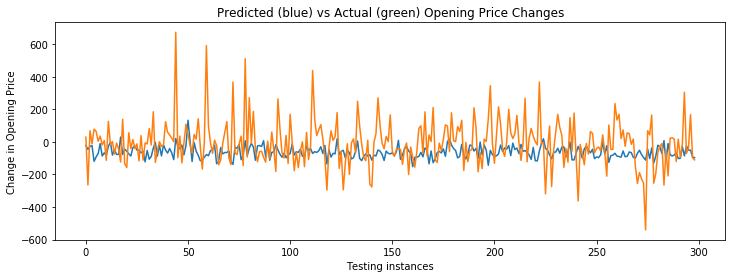

In [89]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [90]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [91]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 56.86% of the time.
